# Competition Objective is to detect fraud in transactions; 

## Data


In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target ```isFraud```.

The data is broken into two files **identity** and **transaction**, which are joined by ```TransactionID```. 

> Note: Not all transactions have corresponding identity information.

**Categorical Features - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**

- DeviceType
- DeviceInfo
- id_12 - id_38

**The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**

# Questions
I will start exploring based on Categorical Features and Transaction Amounts.
The aim is answer some questions like:
- What type of data we have on our data?
- How many cols, rows, missing values we have?
- Whats the target distribution?
- What's the Transactions values distribution of fraud and no fraud transactions?
- We have predominant fraudulent products? 
- What features or target shows some interesting patterns? 
- And a lot of more questions that will raise trought the exploration. 




## Importing necessary libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing train datasets

In [5]:
df_id = pd.read_csv("/content/drive/MyDrive/IEEE_Fraud_Detection/ieee-fraud-detection/train_identity.csv")
df_trans = pd.read_csv("/content/drive/MyDrive/IEEE_Fraud_Detection/ieee-fraud-detection/train_transaction.csv")

In [6]:
df_trans

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4  card5  ... V330  V331  V332  V333  \
0       13926    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   
1        2755  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   
2        4663  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   
3       18132  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   
4        4497  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   
...       ...    ...    ...         ...    ...  ...  ...   ...   ...   ...   
590535   6550    NaN  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   
590536  10444  225.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   
590537  12037  595.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   
590538   7826  481.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   
590539  15066  170.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   

        V334 V335 V336  V337  V338  V339  
0        NaN  NaN  NaN   NaN   NaN   NaN  
1        NaN  NaN  NaN   NaN   NaN   NaN  
2        NaN  NaN  NaN   NaN   NaN   NaN  
3        NaN  NaN  NaN   NaN   NaN   NaN  
4        0.0  0.0  0.0   0.0   0.0   0.0  
...      ...  ...  ...   ...   ...   ...  
590535   NaN  NaN  NaN   NaN   NaN   NaN  
590536   NaN  NaN  NaN   NaN   NaN   NaN  
590537   NaN  NaN  NaN   NaN   NaN   NaN  
590538   NaN  NaN  NaN   NaN   NaN   NaN  
590539   NaN  NaN  NaN   NaN   NaN   NaN  

[590540 rows x 394 columns]

In [7]:
summary = pd.DataFrame(df_trans.dtypes,columns=['dtypes'])

In [8]:
summary1 = pd.DataFrame(df_trans.dtypes, columns=['dtypes'] )

In [9]:
summary1

dtypes
TransactionID     int64
isFraud           int64
TransactionDT     int64
TransactionAmt  float64
ProductCD        object
...                 ...
V335            float64
V336            float64
V337            float64
V338            float64
V339            float64

[394 rows x 1 columns]

In [10]:
summary1 = summary1.reset_index()

In [11]:
summary1

index   dtypes
0     TransactionID    int64
1           isFraud    int64
2     TransactionDT    int64
3    TransactionAmt  float64
4         ProductCD   object
..              ...      ...
389            V335  float64
390            V336  float64
391            V337  float64
392            V338  float64
393            V339  float64

[394 rows x 2 columns]

In [12]:
summary1['Name'] = summary1['index']

In [13]:
summary1

index   dtypes            Name
0     TransactionID    int64   TransactionID
1           isFraud    int64         isFraud
2     TransactionDT    int64   TransactionDT
3    TransactionAmt  float64  TransactionAmt
4         ProductCD   object       ProductCD
..              ...      ...             ...
389            V335  float64            V335
390            V336  float64            V336
391            V337  float64            V337
392            V338  float64            V338
393            V339  float64            V339

[394 rows x 3 columns]

In [14]:
 summary1 = summary1[['Name','dtypes']]

In [15]:
summary1

Name   dtypes
0     TransactionID    int64
1           isFraud    int64
2     TransactionDT    int64
3    TransactionAmt  float64
4         ProductCD   object
..              ...      ...
389            V335  float64
390            V336  float64
391            V337  float64
392            V338  float64
393            V339  float64

[394 rows x 2 columns]

In [16]:
summary['Missing'] = df_trans.isnull().sum().values 

In [17]:
summary1['Missing']=df_trans.isnull().sum().values #.values is very important here as it gives the total sum of the values that is absent in the feature

In [18]:
summary1

Name   dtypes  Missing
0     TransactionID    int64        0
1           isFraud    int64        0
2     TransactionDT    int64        0
3    TransactionAmt  float64        0
4         ProductCD   object        0
..              ...      ...      ...
389            V335  float64   508189
390            V336  float64   508189
391            V337  float64   508189
392            V338  float64   508189
393            V339  float64   508189

[394 rows x 3 columns]

In [19]:
 summary1['Uniques'] = df_trans.nunique().values

In [20]:
summary1

Name   dtypes  Missing  Uniques
0     TransactionID    int64        0   590540
1           isFraud    int64        0        2
2     TransactionDT    int64        0   573349
3    TransactionAmt  float64        0    20902
4         ProductCD   object        0        5
..              ...      ...      ...      ...
389            V335  float64   508189      672
390            V336  float64   508189      356
391            V337  float64   508189      254
392            V338  float64   508189      380
393            V339  float64   508189      334

[394 rows x 4 columns]

In [21]:
summary1['First Value'] = df_trans.loc[0].values

In [22]:
summary1

Name   dtypes  Missing  Uniques First Value
0     TransactionID    int64        0   590540     2987000
1           isFraud    int64        0        2           0
2     TransactionDT    int64        0   573349       86400
3    TransactionAmt  float64        0    20902        68.5
4         ProductCD   object        0        5           W
..              ...      ...      ...      ...         ...
389            V335  float64   508189      672         NaN
390            V336  float64   508189      356         NaN
391            V337  float64   508189      254         NaN
392            V338  float64   508189      380         NaN
393            V339  float64   508189      334         NaN

[394 rows x 5 columns]

I will set all functions in the cell bellow.

In [23]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary1 = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary1 = summary1.reset_index()
    summary1['Name'] = summary1['index']
    summary1 = summary1[['Name','dtypes']]
    summary1['Missing'] = df.isnull().sum().values    
    summary1['Uniques'] = df.nunique().values
    summary1['First Value'] = df.loc[0].values
    summary1['Second Value'] = df.loc[1].values
    summary1['Third Value'] = df.loc[2].values

    for name in summary1['Name'].value_counts().index: #value counts tells the total number of unique values for the values in name feature.
        summary1.loc[summary1['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 


    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [24]:
summary1['Name'].value_counts()

TransactionID    1
V216             1
V214             1
V213             1
V212             1
                ..
V75              1
V74              1
V73              1
V72              1
V339             1
Name: Name, Length: 394, dtype: int64

To see the output of the Resume Table, click to see the output 

# Knowing the data

In [25]:
resumetable(df_trans)[:25]

Dataset Shape: (590540, 394)


dtypes  Missing
TransactionID     int64        0
isFraud           int64        0
TransactionDT     int64        0
TransactionAmt  float64        0
ProductCD        object        0
card1             int64        0
card2           float64     8933
card3           float64     1565
card4            object     1577
card5           float64     4259
card6            object     1571
addr1           float64    65706
addr2           float64    65706
dist1           float64   352271
dist2           float64   552913
P_emaildomain    object    94456
R_emaildomain    object   453249
C1              float64        0
C2              float64        0
C3              float64        0
C4              float64        0
C5              float64        0
C6              float64        0
C7              float64        0
C8              float64        0

In [26]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)

In [27]:
len(df_trans)

590540

In [28]:
df_trans.shape

(590540, 394)

In [29]:
type(df_trans)

pandas.core.frame.DataFrame

In [30]:
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum() #This statement groups together
#all the transaction values of both the fraud and not fraud and then one sum() is used to add up all the transaction values of 0 and 1 while the secong sum() fn is used to sum up the total amount that include both fraud and not fraud.

In [31]:
total_amt

79738948.735

# Target Distribution

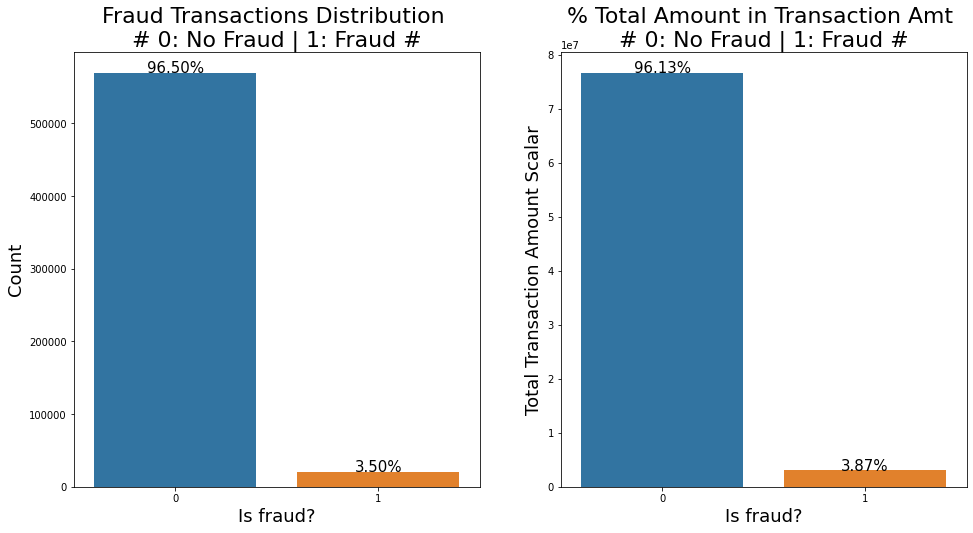

In [32]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float) #converting the column TransactionAmt to float.
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,8))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, ) #is used to generate the count plot.
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches: #This function is used to print the percentage number on top of the plots.
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

In [33]:
perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()

In [34]:
perc_amt

isFraud  TransactionAmt
0        0    7.665510e+07
1        1    3.083845e+06

We have 3.5% of Fraud transactions in our dataset. <br>I think that it would be interesting to see if the amount percentual is higher or lower than 3.5% of total. I will see it later. <br>
We have the same % when considering the Total Transactions Amount by Fraud and No Fraud. <br>
Let's explore the Transaction amount further below.

# Transaction Amount Quantiles

Before Ploting the Transaction Amount, let's see the quantiles of Transaction Amount

In [35]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010       9.2440
0.025      14.5010
0.100      25.9500
0.250      43.3210
0.500      68.7690
0.750     125.0000
0.900     275.2930
0.975     648.3345
0.990    1104.0000
Name: TransactionAmt, dtype: float64


# Ploting Transaction Amount Values Distribution

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



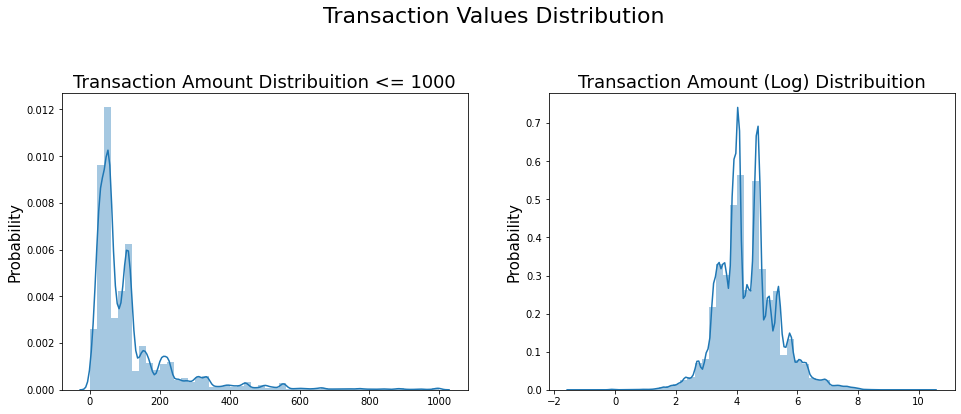

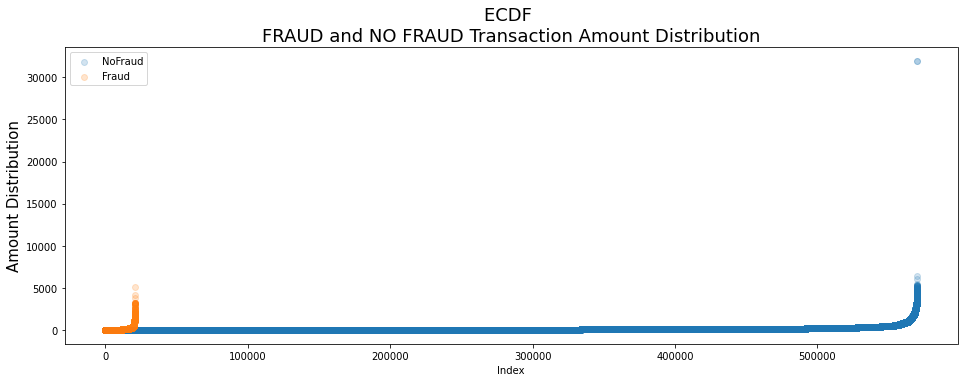

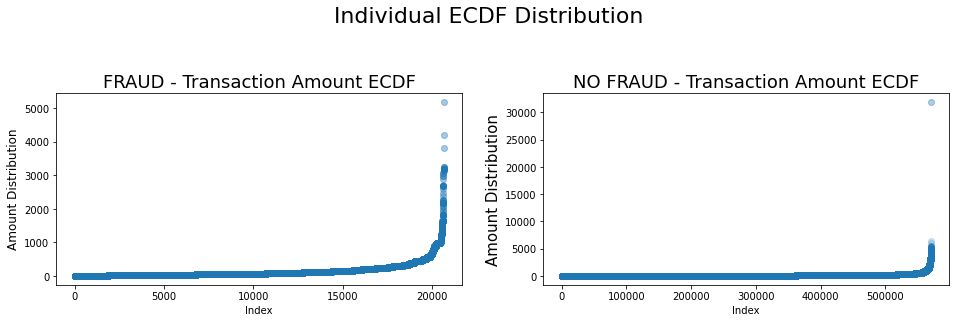

In [36]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
g4= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]), 
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g1= plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()

In [37]:
range(df_trans[df_trans['isFraud'] == 0].shape[0])

range(0, 569877)

In [38]:
df_trans[df_trans['isFraud'] == 1].shape[0]

20663

In [39]:
type(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values)

numpy.ndarray

Nice! Now, we can see clearly the distribution of 

# Seeing the Quantiles of Fraud and No Fraud Transactions

In [40]:
print(pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01        6.74096     0.01        9.51288
1  0.10       18.93600     0.10       26.31000
2  0.25       35.04400     0.25       43.97000
3  0.50       75.00000     0.50       68.50000
4  0.75      161.00000     0.75      120.00000
5  0.90      335.00000     0.90      267.11200
6  0.99      994.00000     0.99     1104.00000


# Transaction Amount Outliers
- It's considering outlier values that are highest than 3 times the std from the mean

In [41]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10093
Total outlier observations: 10093
Non-outlier observations: 580447
Total percentual of Outliers:  1.7388


If we consider only values between >= 0 to 800 we will avoid the outliers and has more confidence in our distribution. <br>
We have 10k rows with outliers that represents 1.74% of total rows.

# Now, let's explore the Product Feature
- Distribution Products
- Distribution of Frauds by Product
- Has Difference between Transaction Amounts in Products? 

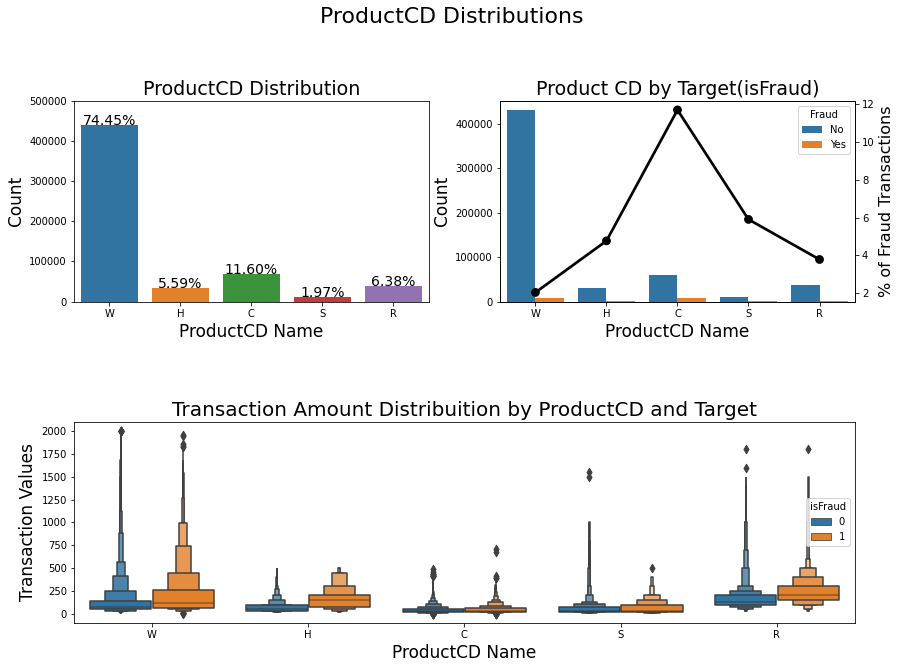

In [42]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

Text(0, 0.5, '% of Fraud Transactions')

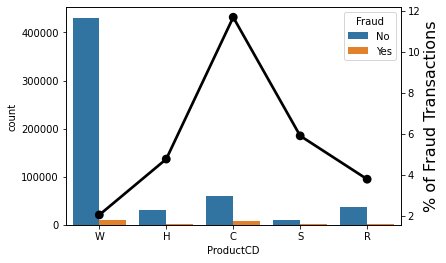

In [43]:
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)


In [44]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()


In [45]:
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

In [46]:
tmp

isFraud ProductCD    NoFraud      Fraud
0               C  88.312731  11.687269
1               H  95.233769   4.766231
2               R  96.217406   3.782594
3               S  94.100447   5.899553
4               W  97.960061   2.039939

In [47]:
tmp

isFraud ProductCD    NoFraud      Fraud
0               C  88.312731  11.687269
1               H  95.233769   4.766231
2               R  96.217406   3.782594
3               S  94.100447   5.899553
4               W  97.960061   2.039939

W, C and R are the most frequent values. <br>
We can note that in W, H and R the distribution of Fraud values are slightly higher than the Non-Fraud Transactions

# Card Features
- Based on Competition Description, card features are categoricals.
- Lets understand the distribution of values
- What's the different in transactions and % of Fraud for each values in these features
- Card features has 6 columns, and 4 of them seems to be numericals, so lets see the quantiles and distributions

In [48]:
df_trans

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4  card5  ... V330  V331  V332  V333  \
0       13926    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   
1        2755  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   
2        4663  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   
3       18132  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   
4        4497  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   
...       ...    ...    ...         ...    ...  ...  ...   ...   ...   ...   
590535   6550    NaN  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   
590536  10444  225.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   
590537  12037  595.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   
590538   7826  481.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   
590539  15066  170.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   

        V334 V335 V336  V337  V338  V339  
0        NaN  NaN  NaN   NaN   NaN   NaN  
1        NaN  NaN  NaN   NaN   NaN   NaN  
2        NaN  NaN  NaN   NaN   NaN   NaN  
3        NaN  NaN  NaN   NaN   NaN   NaN  
4        0.0  0.0  0.0   0.0   0.0   0.0  
...      ...  ...  ...   ...   ...   ...  
590535   NaN  NaN  NaN   NaN   NaN   NaN  
590536   NaN  NaN  NaN   NaN   NaN   NaN  
590537   NaN  NaN  NaN   NaN   NaN   NaN  
590538   NaN  NaN  NaN   NaN   NaN   NaN  
590539   NaN  NaN  NaN   NaN   NaN   NaN  

[590540 rows x 394 columns]

In [49]:
## Knowning the Card Features
resumetable(df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


dtypes  Missing
TransactionID     int64        0
isFraud           int64        0
TransactionDT     int64        0
TransactionAmt  float64        0
ProductCD        object        0
...                 ...      ...
V335            float64   508189
V336            float64   508189
V337            float64   508189
V338            float64   508189
V339            float64   508189

[394 rows x 2 columns]

Card2-Card6 has some missing values. We will need to due with it later.

# Numericals Feature Card Quantiles

In [50]:
print("Card Features Quantiles: ")
print(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles: 
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


We can see that Card 1 and Card 2 has a large distribution of values, so maybe it will be better to get the log of these columns

In [51]:
#These 2 lines are for changing the values of the features card3 and card5. Only those feature values whoose counts are less than 200 in card 3 and 300 in card 5.
df_trans.loc[df_trans.card3.isin(df_trans.card3.value_counts()[df_trans.card3.value_counts() < 200].index), 'card3'] = "Others"
df_trans.loc[df_trans.card5.isin(df_trans.card5.value_counts()[df_trans.card5.value_counts() < 300].index), 'card5'] = "Others"

In [52]:
df_trans

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4   card5  ... V330  V331  V332  V333  \
0       13926    NaN  150.0    discover  Others  ...  NaN   NaN   NaN   NaN   
1        2755  404.0  150.0  mastercard   102.0  ...  NaN   NaN   NaN   NaN   
2        4663  490.0  150.0        visa   166.0  ...  NaN   NaN   NaN   NaN   
3       18132  567.0  150.0  mastercard   117.0  ...  NaN   NaN   NaN   NaN   
4        4497  514.0  150.0  mastercard   102.0  ...  0.0   0.0   0.0   0.0   
...       ...    ...    ...         ...     ...  ...  ...   ...   ...   ...   
590535   6550    NaN  150.0        visa   226.0  ...  NaN   NaN   NaN   NaN   
590536  10444  225.0  150.0  mastercard   224.0  ...  NaN   NaN   NaN   NaN   
590537  12037  595.0  150.0  mastercard   224.0  ...  NaN   NaN   NaN   NaN   
590538   7826  481.0  150.0  mastercard   224.0  ...  NaN   NaN   NaN   NaN   
590539  15066  170.0  150.0  mastercard   102.0  ...  NaN   NaN   NaN   NaN   

        V334 V335 V336  V337  V338  V339  
0        NaN  NaN  NaN   NaN   NaN   NaN  
1        NaN  NaN  NaN   NaN   NaN   NaN  
2        NaN  NaN  NaN   NaN   NaN   NaN  
3        NaN  NaN  NaN   NaN   NaN   NaN  
4        0.0  0.0  0.0   0.0   0.0   0.0  
...      ...  ...  ...   ...   ...   ...  
590535   NaN  NaN  NaN   NaN   NaN   NaN  
590536   NaN  NaN  NaN   NaN   NaN   NaN  
590537   NaN  NaN  NaN   NaN   NaN   NaN  
590538   NaN  NaN  NaN   NaN   NaN   NaN  
590539   NaN  NaN  NaN   NaN   NaN   NaN  

[590540 rows x 394 columns]

In [53]:
print(df_trans.card3.value_counts()[df_trans.card3.value_counts() < 200].index)

Index([], dtype='object')


# Visualizing Card 1, Card 2 and Card 3 Distributions
- As the Card 1 and 2 are numericals, I will plot the distribution of them
- in Card 3, as we have many values with low frequencies, I decided to set value to "Others" 
- Also, in Card 3 I set the % of Fraud ratio in yaxis2

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/di

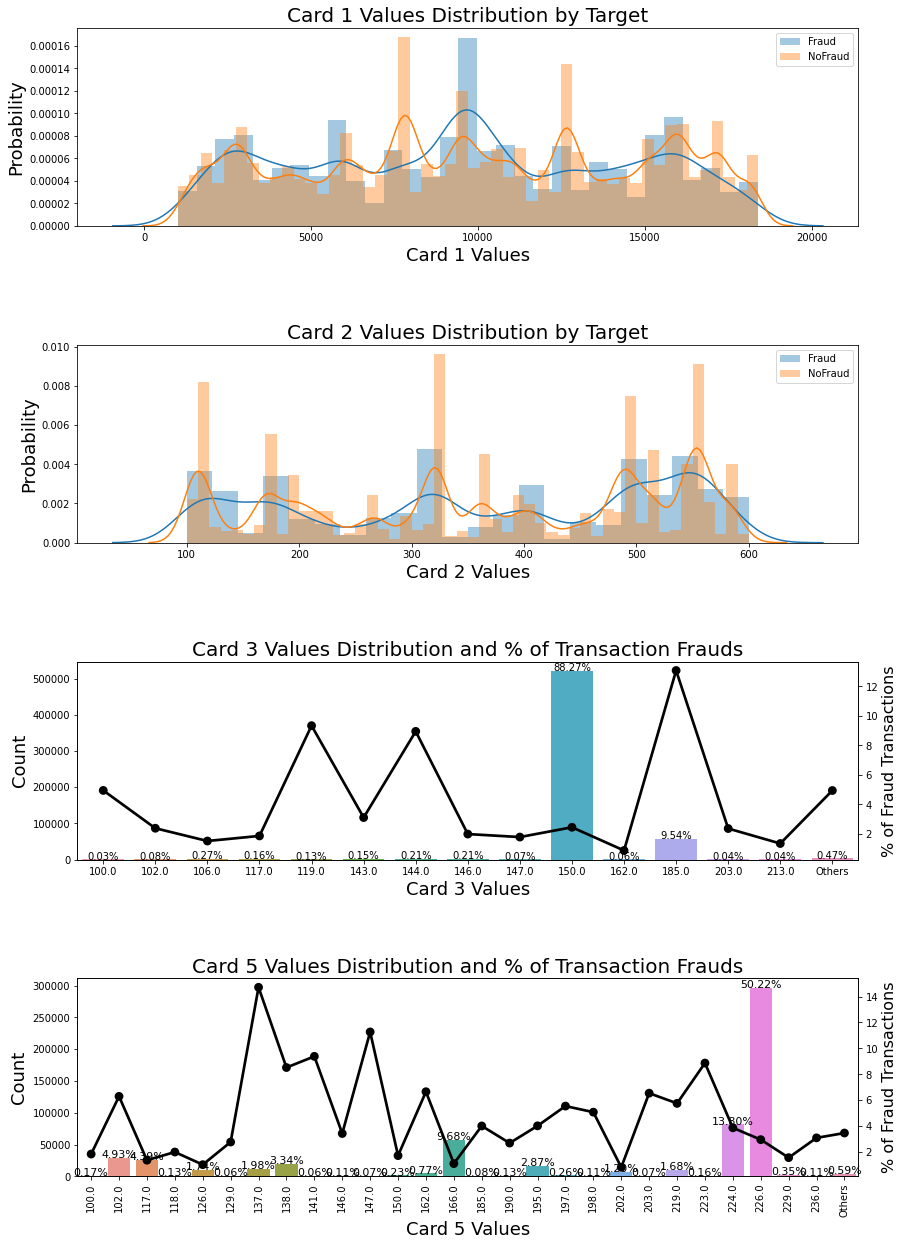

In [54]:
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=df_trans, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=df_trans, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

In [55]:
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100

In [56]:
tmp = tmp.reset_index()

In [57]:
tmp

isFraud   card3          0          1
0         100.0  95.049505   4.950495
1         102.0  97.608696   2.391304
2         106.0  98.472311   1.527689
3         117.0  98.128898   1.871102
4         119.0  90.666667   9.333333
5         143.0  96.885428   3.114572
6         144.0  91.054313   8.945687
7         146.0  98.003195   1.996805
8         147.0  98.205128   1.794872
9         150.0  97.543196   2.456804
10        162.0  99.115044   0.884956
11        185.0  86.934299  13.065701
12        203.0  97.628458   2.371542
13        213.0  98.642534   1.357466
14       Others  95.055536   4.944464

Cool and Very Meaningful information. <br>
In Card3 we can see that 100 and 106 are the most common values in the column. <br>
We have 4.95% of Frauds in 100 and 1.52% in 106; The values with highest Fraud Transactions are 185, 144 and 119; <br>

In card5 the most frequent values are 226, 224, 166 that represents 73% of data. Also is posible to see high % of frauds in 137, 147, 141 that has few entries for values.

# Card 4 - Categorical

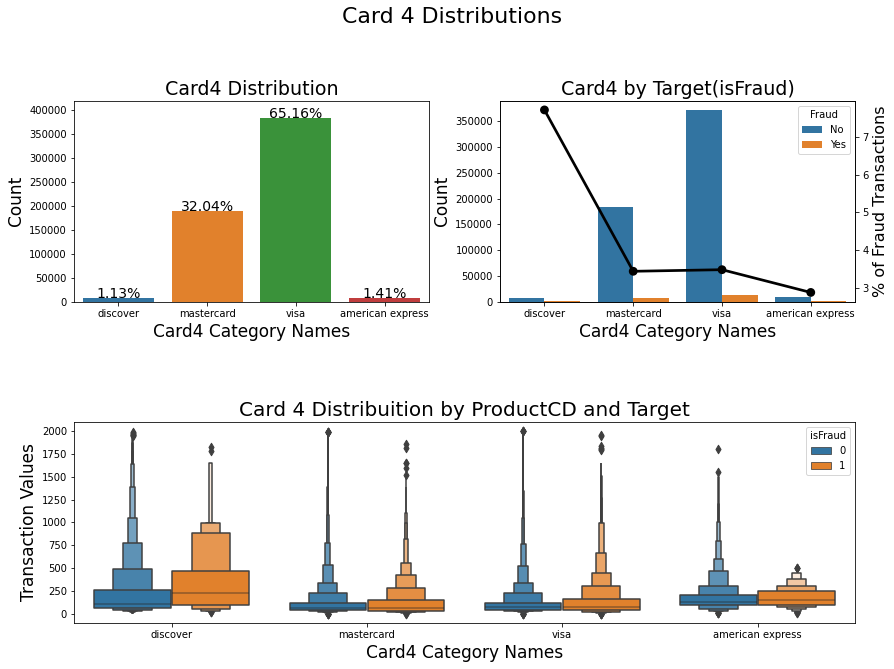

In [58]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card4 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

We can see that 97% of our data are in Mastercard(32%) and Visa(65%);  <br>
we have a highest value in discover(~8%) against ~3.5% of Mastercard and Visa and 2.87% in American Express

# Card 6 - Categorical

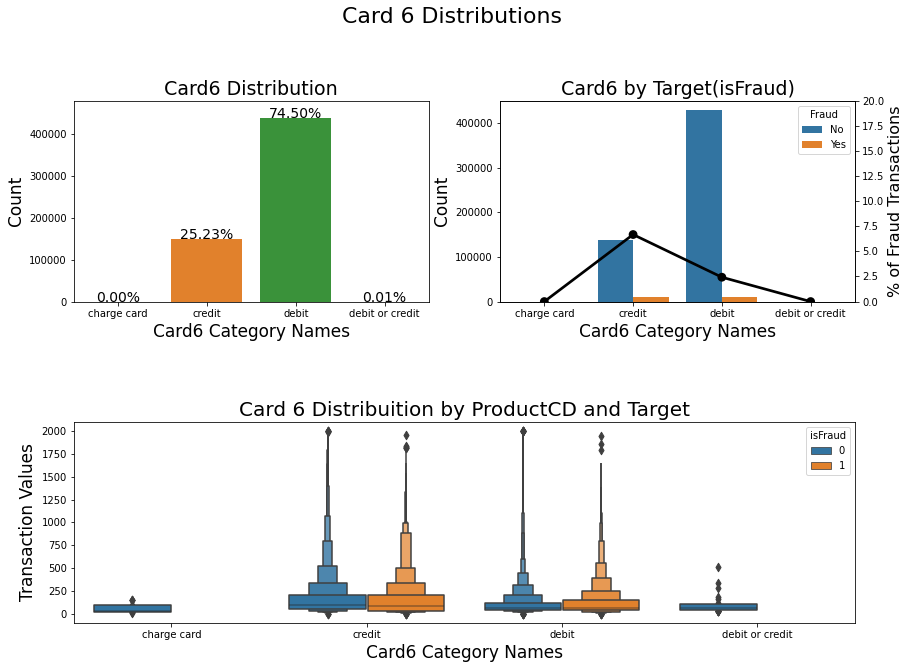

In [59]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=df_trans, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=df_trans, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card6 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [60]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud']) 

In [61]:
tmp

isFraud               0      1
card6                         
charge card          15      0
credit           139036   9950
debit            429264  10674
debit or credit      30      0

In [62]:
g.patches

All data is on Credit and Debit. We can see a high percentual of Frauds in Credit than Debit transactions. <br>
The Distribution of Transaction Amount don't shows clear differences.

# Exploring M1-M9 Features 

In [63]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']: #this for loop is just to fill up the missing values in the specifies features.
    df_trans[col] = df_trans[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (df_trans.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()


In [64]:
perc_amt = (df_trans.groupby(['isFraud','M1'])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
perc_amt 

isFraud          0         1
M1                          
F         0.004843       NaN
Miss     36.573341  1.969276
T        59.554389  1.898150

In [65]:
tmp = pd.crosstab(df_trans['M2'], df_trans['isFraud'], normalize='index') * 100

In [66]:
tmp

isFraud          0         1
M2                          
F        96.514777  3.485223
Miss     94.717447  5.282553
T        98.193142  1.806858

In [67]:
df_trans

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4   card5  ... V330  V331  V332  V333  \
0       13926    NaN  150.0    discover  Others  ...  NaN   NaN   NaN   NaN   
1        2755  404.0  150.0  mastercard   102.0  ...  NaN   NaN   NaN   NaN   
2        4663  490.0  150.0        visa   166.0  ...  NaN   NaN   NaN   NaN   
3       18132  567.0  150.0  mastercard   117.0  ...  NaN   NaN   NaN   NaN   
4        4497  514.0  150.0  mastercard   102.0  ...  0.0   0.0   0.0   0.0   
...       ...    ...    ...         ...     ...  ...  ...   ...   ...   ...   
590535   6550    NaN  150.0        visa   226.0  ...  NaN   NaN   NaN   NaN   
590536  10444  225.0  150.0  mastercard   224.0  ...  NaN   NaN   NaN   NaN   
590537  12037  595.0  150.0  mastercard   224.0  ...  NaN   NaN   NaN   NaN   
590538   7826  481.0  150.0  mastercard   224.0  ...  NaN   NaN   NaN   NaN   
590539  15066  170.0  150.0  mastercard   102.0  ...  NaN   NaN   NaN   NaN   

        V334 V335 V336  V337  V338  V339  
0        NaN  NaN  NaN   NaN   NaN   NaN  
1        NaN  NaN  NaN   NaN   NaN   NaN  
2        NaN  NaN  NaN   NaN   NaN   NaN  
3        NaN  NaN  NaN   NaN   NaN   NaN  
4        0.0  0.0  0.0   0.0   0.0   0.0  
...      ...  ...  ...   ...   ...   ...  
590535   NaN  NaN  NaN   NaN   NaN   NaN  
590536   NaN  NaN  NaN   NaN   NaN   NaN  
590537   NaN  NaN  NaN   NaN   NaN   NaN  
590538   NaN  NaN  NaN   NaN   NaN   NaN  
590539   NaN  NaN  NaN   NaN   NaN   NaN  

[590540 rows x 394 columns]

## M distributions:  Count, %Fraud and Transaction Amount distribution

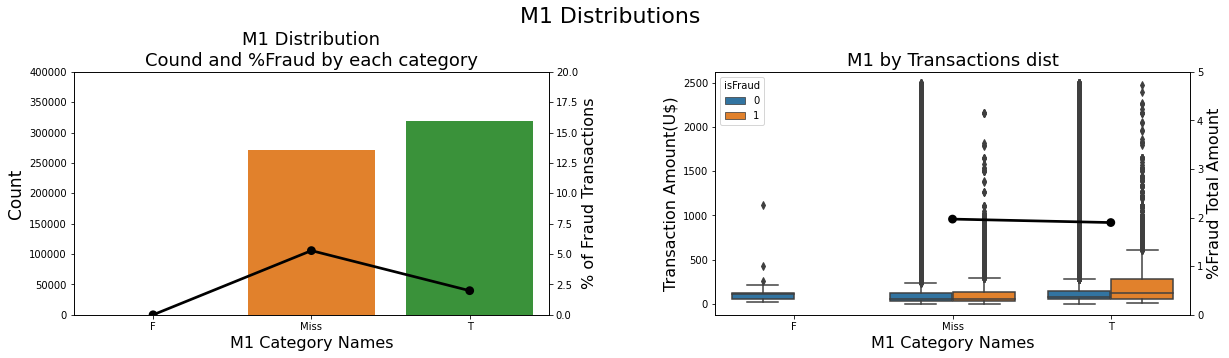

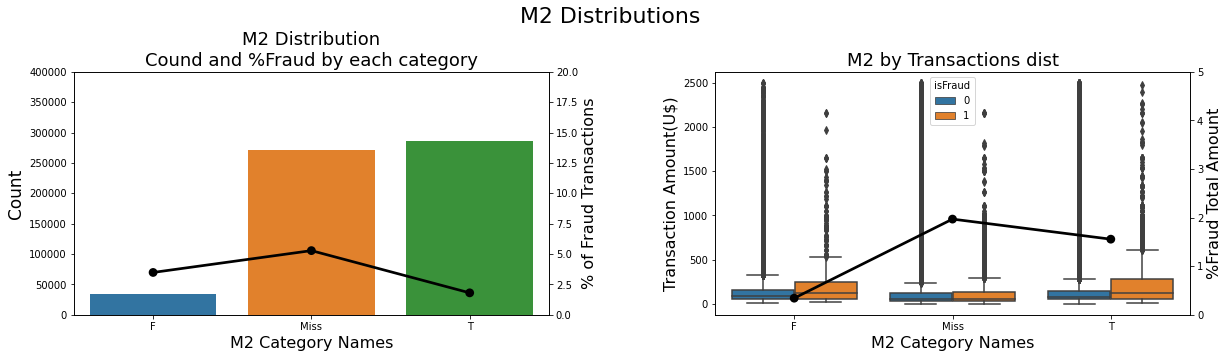

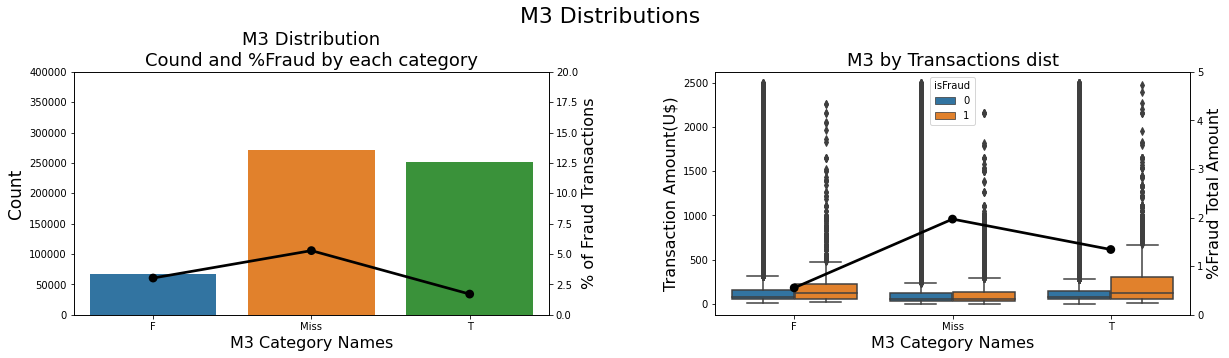

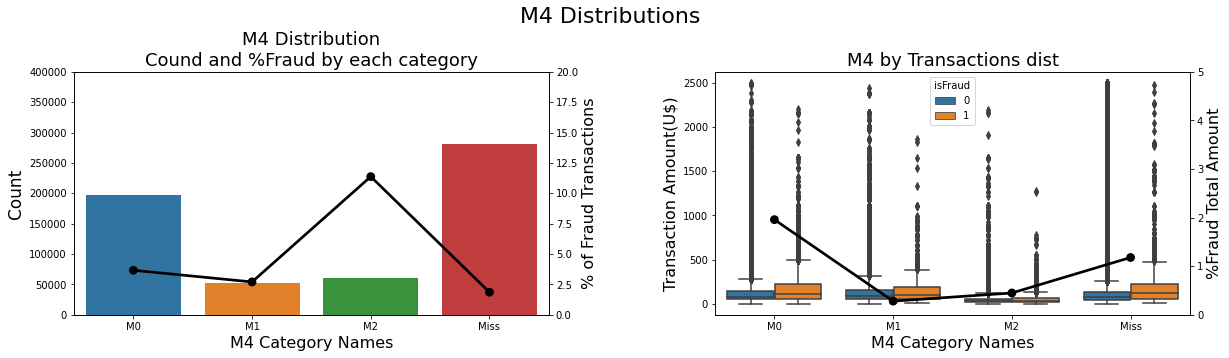

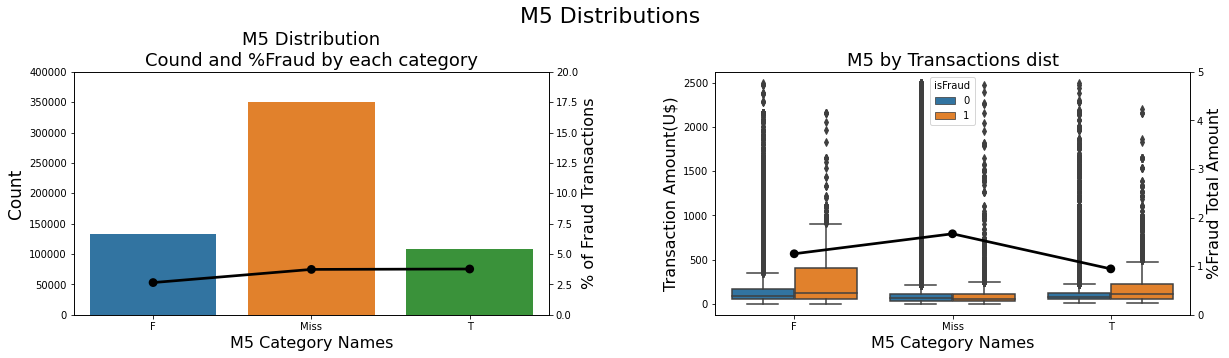

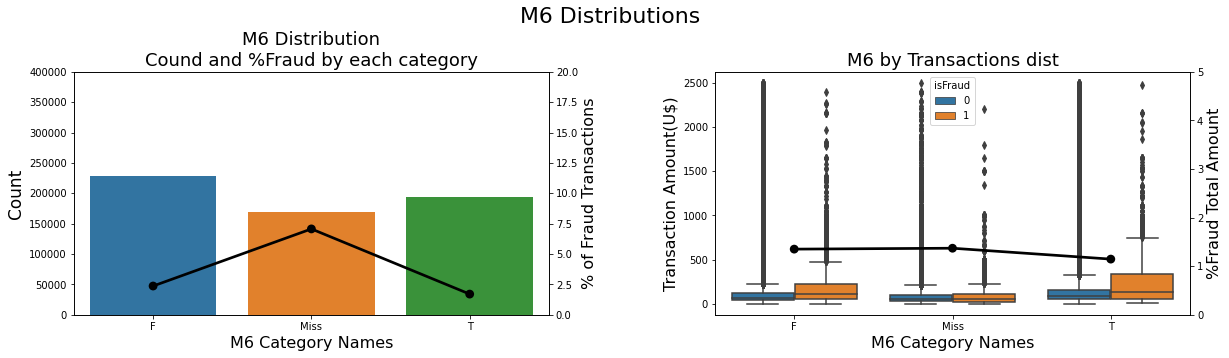

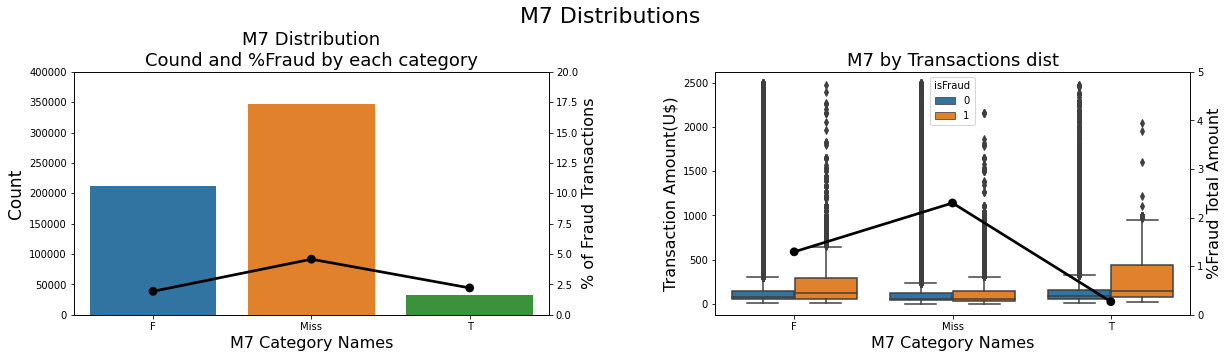

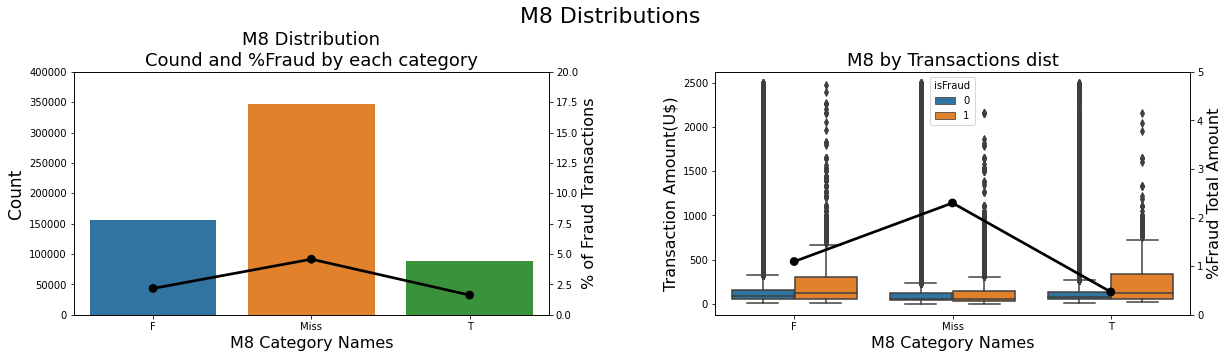

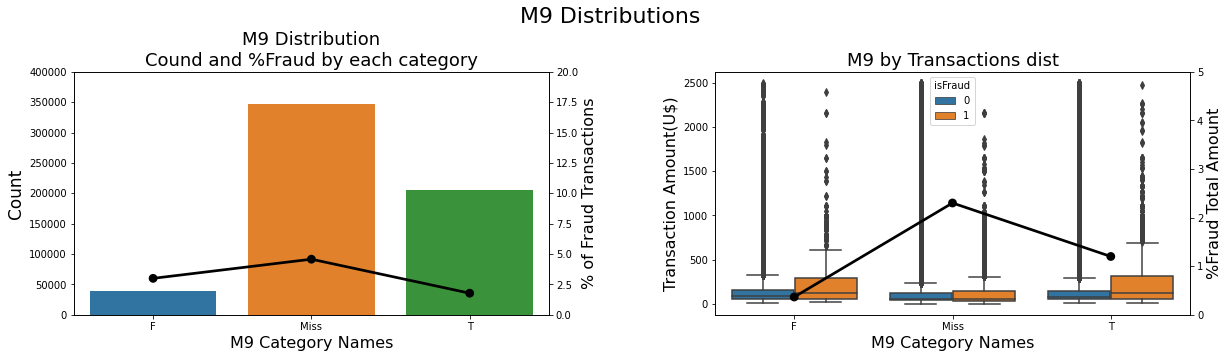

In [68]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(df_trans, col, lim=2500)

Very cool!!! This graphs give us many interesting intuition about the M features.<br>
Only in M4 the Missing values haven't the highest % of Fraud.



# Addr1 and Addr2

In [69]:
df_trans['addr1']

0         315.0
1         325.0
2         330.0
3         476.0
4         420.0
          ...  
590535    272.0
590536    204.0
590537    231.0
590538    387.0
590539    299.0
Name: addr1, Length: 590540, dtype: float64

In [70]:
print("Card Features Quantiles: ")
print(df_trans[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


I will set all values in Addr1 that has less than 5000 entries to "Others"<br>
In Addr2 I will set as "Others" all values with less than 50 entries

In [71]:
#very important statements they do the same functions as mentioned above
df_trans.loc[df_trans.addr1.isin(df_trans.addr1.value_counts()[df_trans.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
df_trans.loc[df_trans.addr2.isin(df_trans.addr2.value_counts()[df_trans.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

## Addr1 Distributions

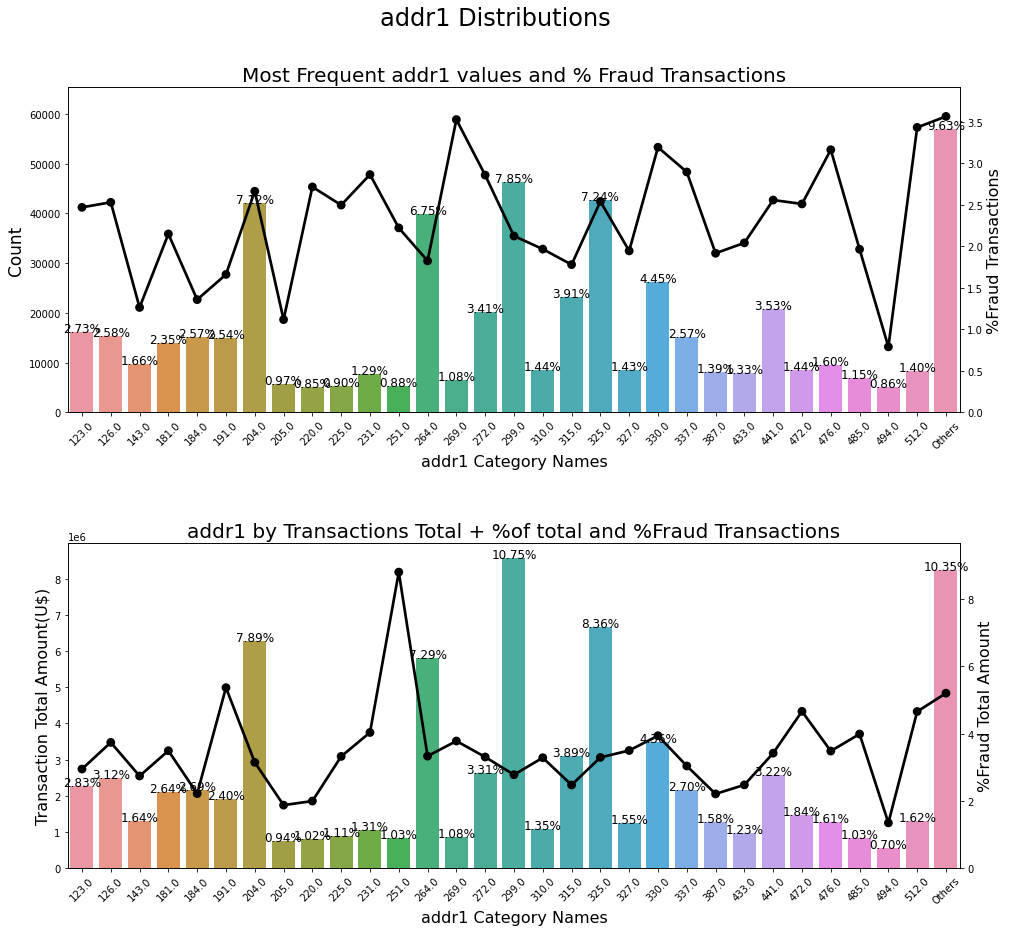

In [72]:
 def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(df_trans, 'addr1')

We can note interesting patterns on Addr1.

## Addr2 Distributions

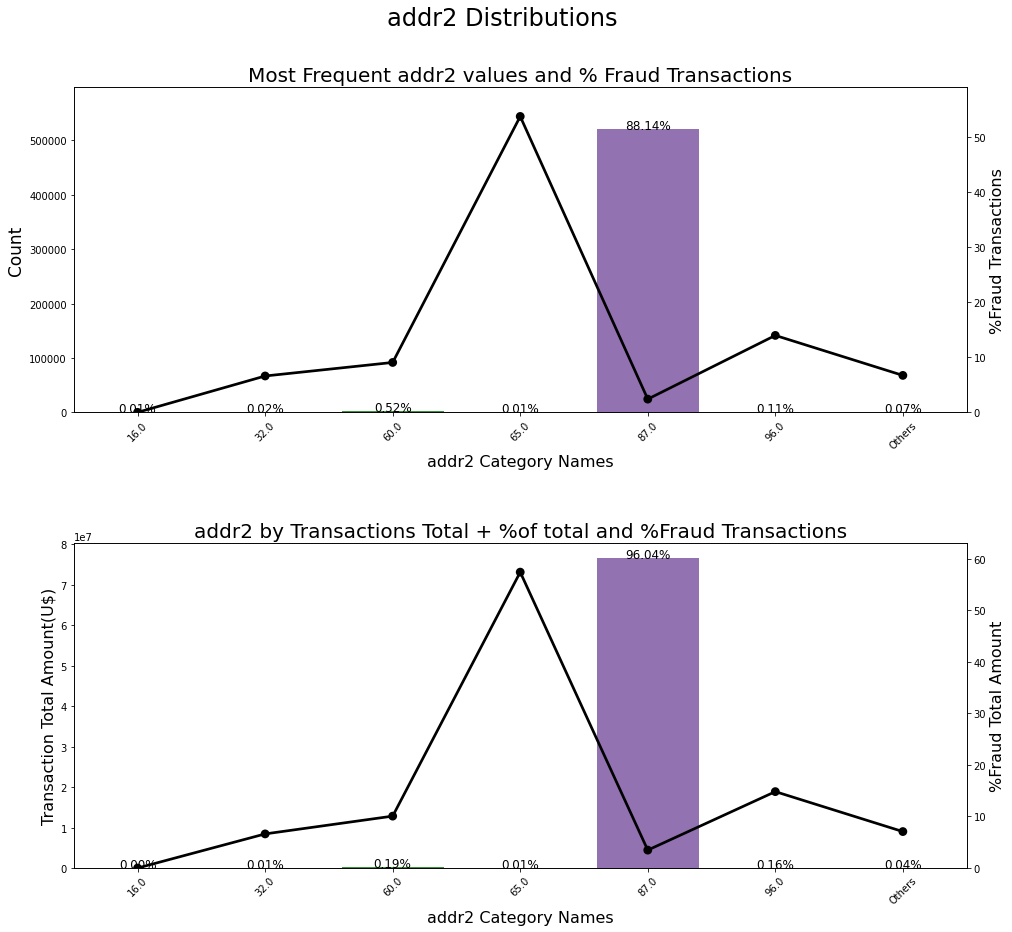

In [73]:
ploting_cnt_amt(df_trans, 'addr2')

Almost all entries in Addr2 are in the same value. <br>
Interestingly in the value 65 , the percent of frauds are almost 60% <br>
Altought the value 87 has 88% of total entries, it has 96% of Total Transaction Amounts

# P emaildomain Distributions
- I will group all e-mail domains by the respective enterprises.
- Also, I will set as "Others" all values with less than 500 entries.

In [74]:
df_trans['P_emaildomain']

0                 NaN
1           gmail.com
2         outlook.com
3           yahoo.com
4           gmail.com
             ...     
590535            NaN
590536      gmail.com
590537      gmail.com
590538        aol.com
590539      gmail.com
Name: P_emaildomain, Length: 590540, dtype: object

In [75]:
df_trans.loc[df_trans['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df_trans.loc[df_trans['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.P_emaildomain.isin(df_trans.P_emaildomain\
                                         .value_counts()[df_trans.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df_trans.P_emaildomain.fillna("NoInf", inplace=True)

## Ploting P-Email Domain

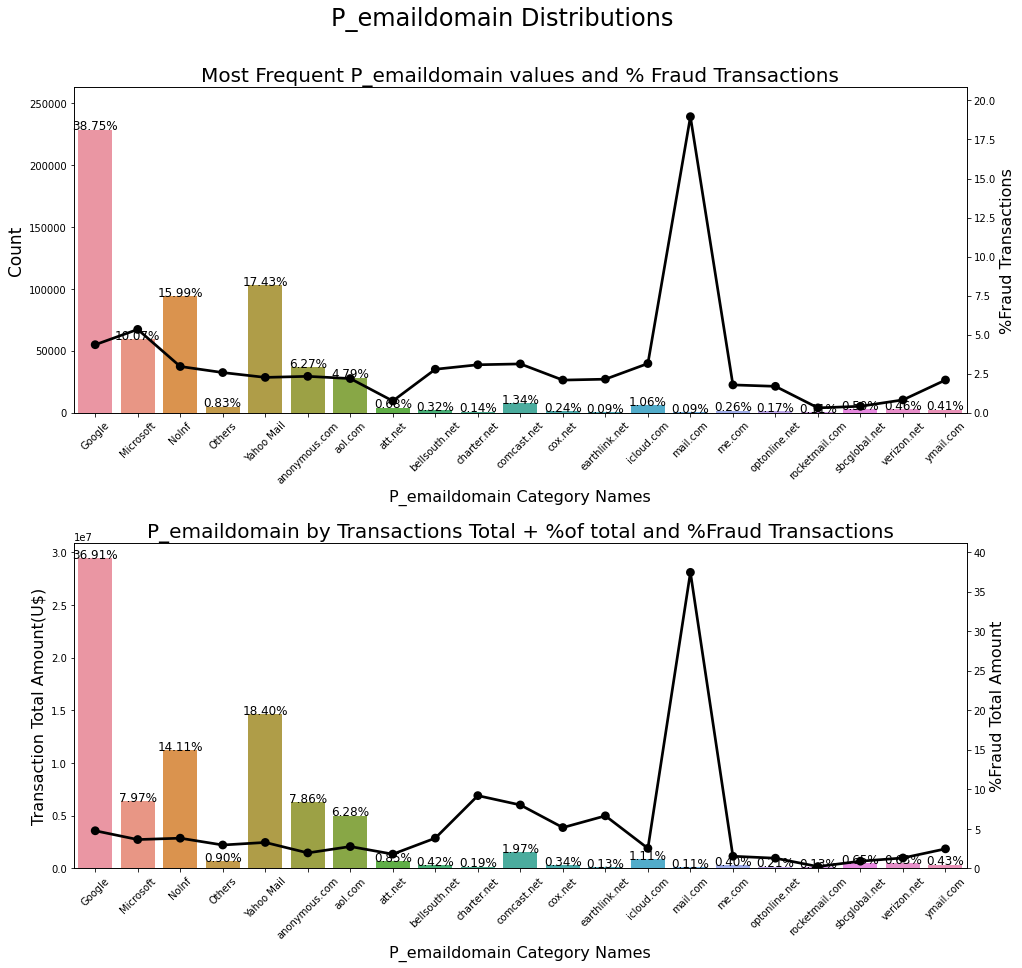

In [76]:
ploting_cnt_amt(df_trans, 'P_emaildomain')

## R-Email Domain plot distribution
- I will group all e-mail domains by the respective enterprises.
- I will set as "Others" all values with less than 300 entries.

In [77]:
df_trans.loc[df_trans['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df_trans.loc[df_trans['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.R_emaildomain.isin(df_trans.R_emaildomain\
                                         .value_counts()[df_trans.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df_trans.R_emaildomain.fillna("NoInf", inplace=True)

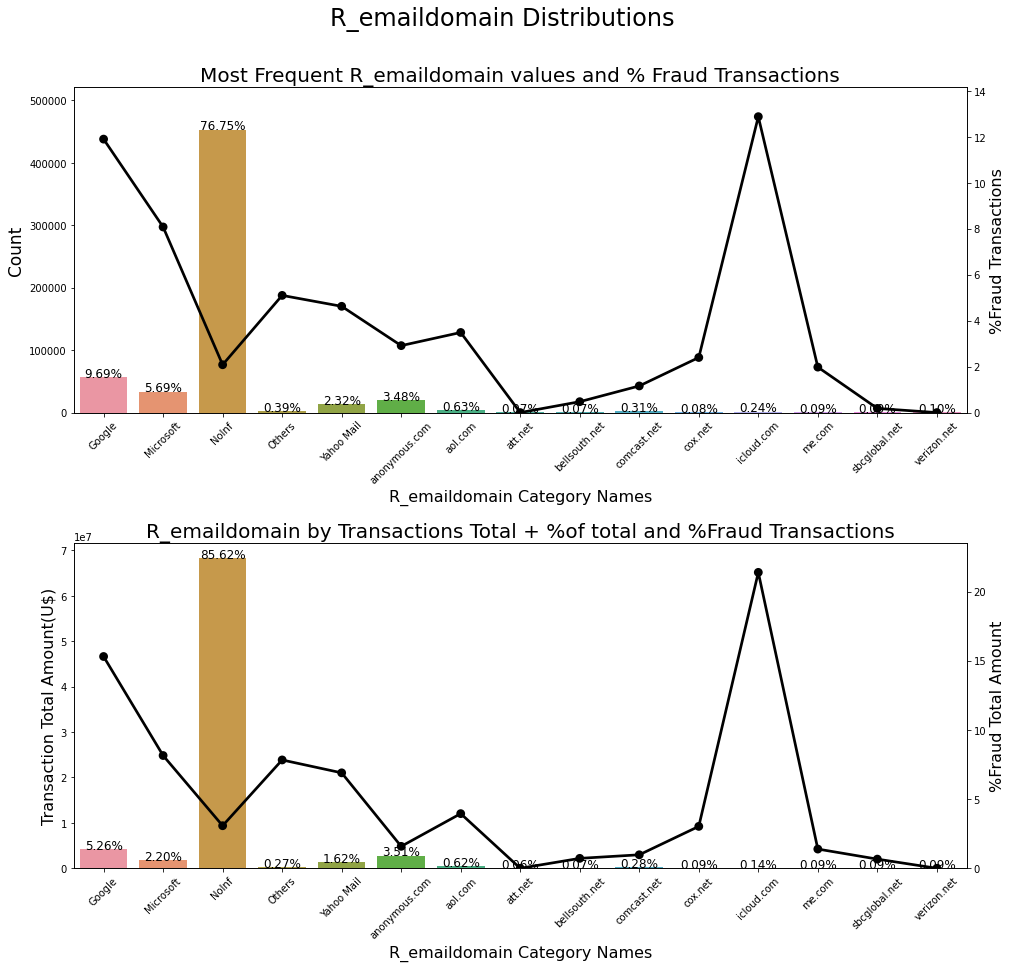

In [78]:
ploting_cnt_amt(df_trans, 'R_emaildomain')

We can see a very similar distribution in both email domain features. <br>
It's interesting that we have high values in google and icloud frauds

# C1-C14 features
- Let's understand what this features are.
- What's the distributions? 

In [79]:
resumetable(df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


dtypes  Missing
TransactionID     int64        0
isFraud           int64        0
TransactionDT     int64        0
TransactionAmt  float64        0
ProductCD        object        0
...                 ...      ...
V335            float64   508189
V336            float64   508189
V337            float64   508189
V338            float64   508189
V339            float64   508189

[394 rows x 2 columns]

In [80]:
df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

C1             C2             C3             C4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458      15.269734       0.005644       4.092185   
std       133.569018     154.668899       0.150536      68.848459   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max      4685.000000    5691.000000      26.000000    2253.000000   

                  C5             C6             C7             C8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        5.571526       9.071082       2.848478       5.144574   
std        25.786976      71.508467      61.727304      95.378574   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       2.000000       0.000000       0.000000   
max       349.000000    2253.000000    2255.000000    3331.000000   

                  C9            C10            C11            C12  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        4.480240       5.240343      10.241521       4.076227   
std        16.674897      95.581443      94.336292      86.666218   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         2.000000       0.000000       2.000000       0.000000   
max       210.000000    3257.000000    3188.000000    3188.000000   

                 C13            C14  
count  590540.000000  590540.000000  
mean       32.539918       8.295215  
std       129.364844      49.544262  
min         0.000000       0.000000  
25%         1.000000       1.000000  
50%         3.000000       1.000000  
75%        12.000000       2.000000  
max      2918.000000    1429.000000

In [81]:
df_trans.loc[df_trans.C1.isin(df_trans.C1\
                              .value_counts()[df_trans.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

## C1 Distribution Plot

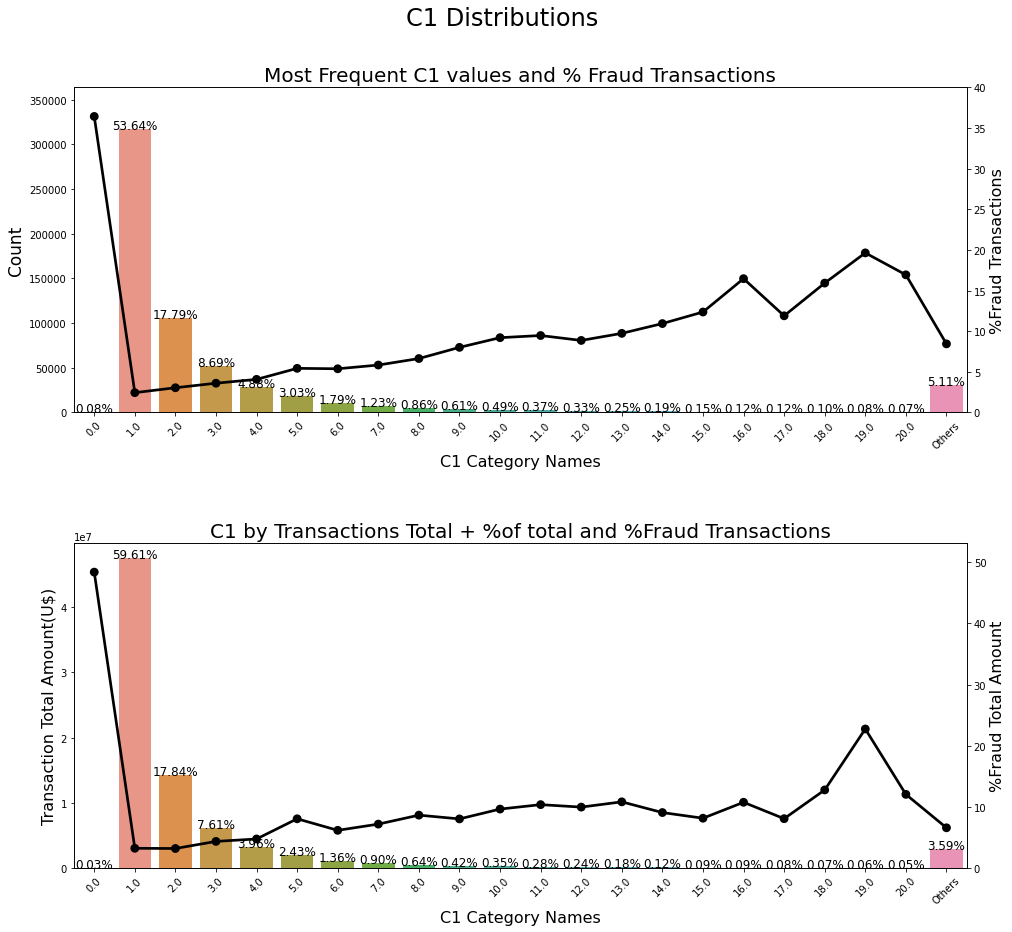

In [82]:
ploting_cnt_amt(df_trans, 'C1')

In [83]:
df_trans.loc[df_trans.C2.isin(df_trans.C2\
                              .value_counts()[df_trans.C2.value_counts() <= 350 ]\
                              .index), 'C2'] = "Others"

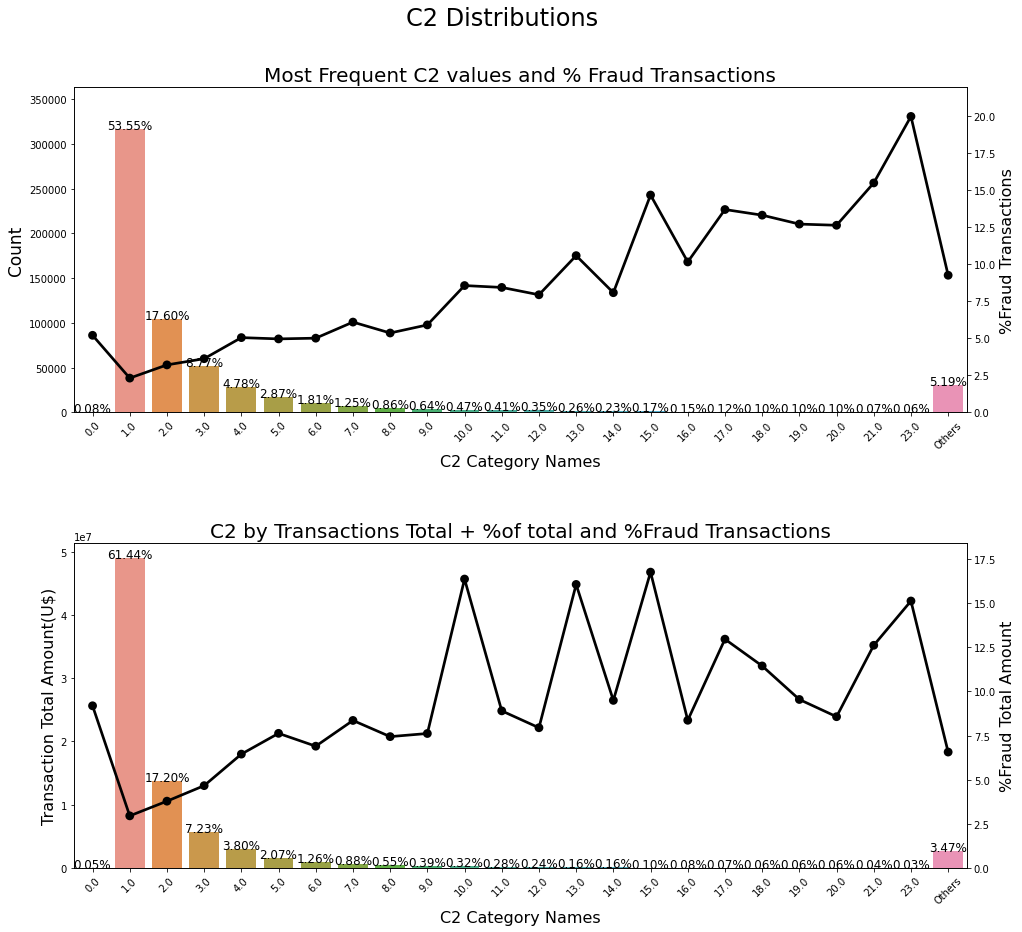

In [84]:
ploting_cnt_amt(df_trans, 'C2')

Top 3 values are 1, 2 and 3 and is the same on Total Amounts. We see the same pattern on fraud ratios

# TimeDelta Feature
- Let's see if the frauds have some specific hour that has highest % of frauds 

## Converting to Total Days, Weekdays and Hours
In discussions tab I read an excellent solution to Timedelta column, I will set the link below; <br>
We will use the first date as 2017-12-01 and use the delta time to compute datetime features


In [85]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_trans["Date"] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

In [86]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

In [87]:
df_trans["Date"] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

In [88]:
df_trans["Date"]

0        2017-12-02 00:00:00
1        2017-12-02 00:00:01
2        2017-12-02 00:01:09
3        2017-12-02 00:01:39
4        2017-12-02 00:01:46
                 ...        
590535   2018-06-01 23:57:27
590536   2018-06-01 23:57:29
590537   2018-06-01 23:57:59
590538   2018-06-01 23:58:08
590539   2018-06-01 23:58:51
Name: Date, Length: 590540, dtype: datetime64[ns]

## Top Days with highest Total Transaction Amount

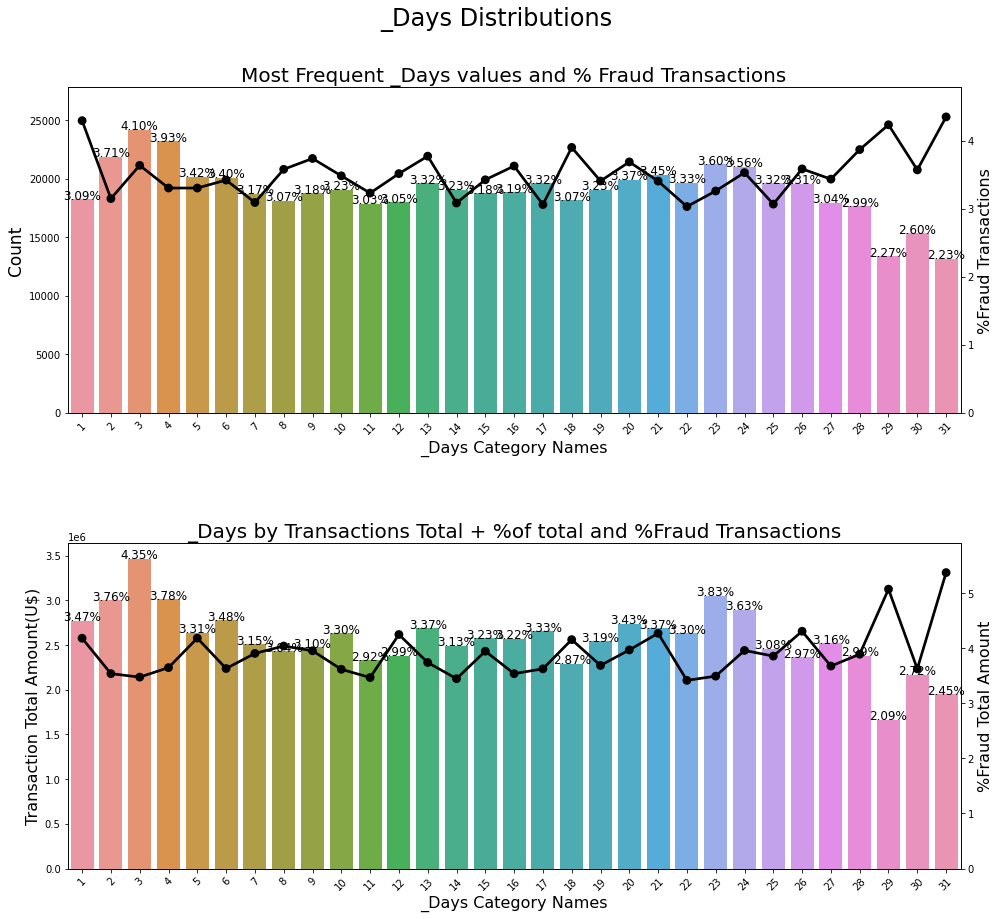

In [89]:
ploting_cnt_amt(df_trans, '_Days')

## Ploting WeekDays Distributions

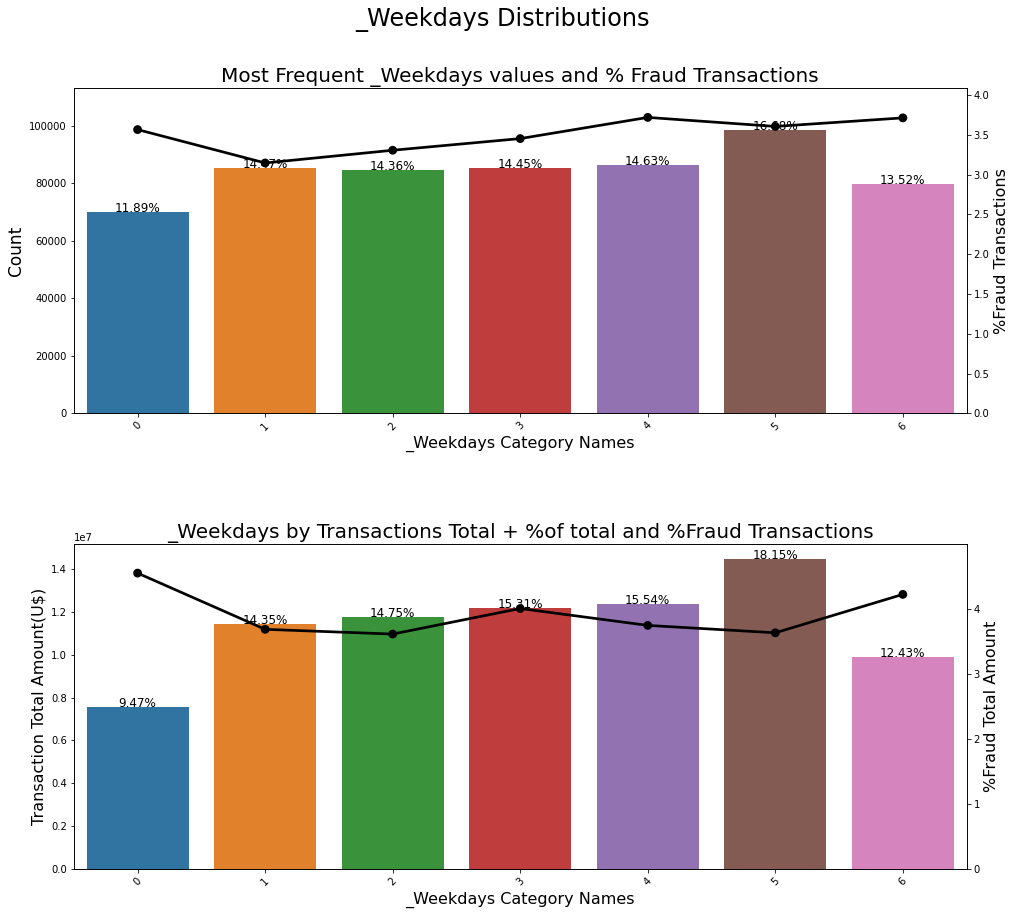

In [90]:
ploting_cnt_amt(df_trans, '_Weekdays')

We don't have the reference of date but we can see that two days has lower transactions, that we can infer it is weekend days

## Ploting Hours Distributions

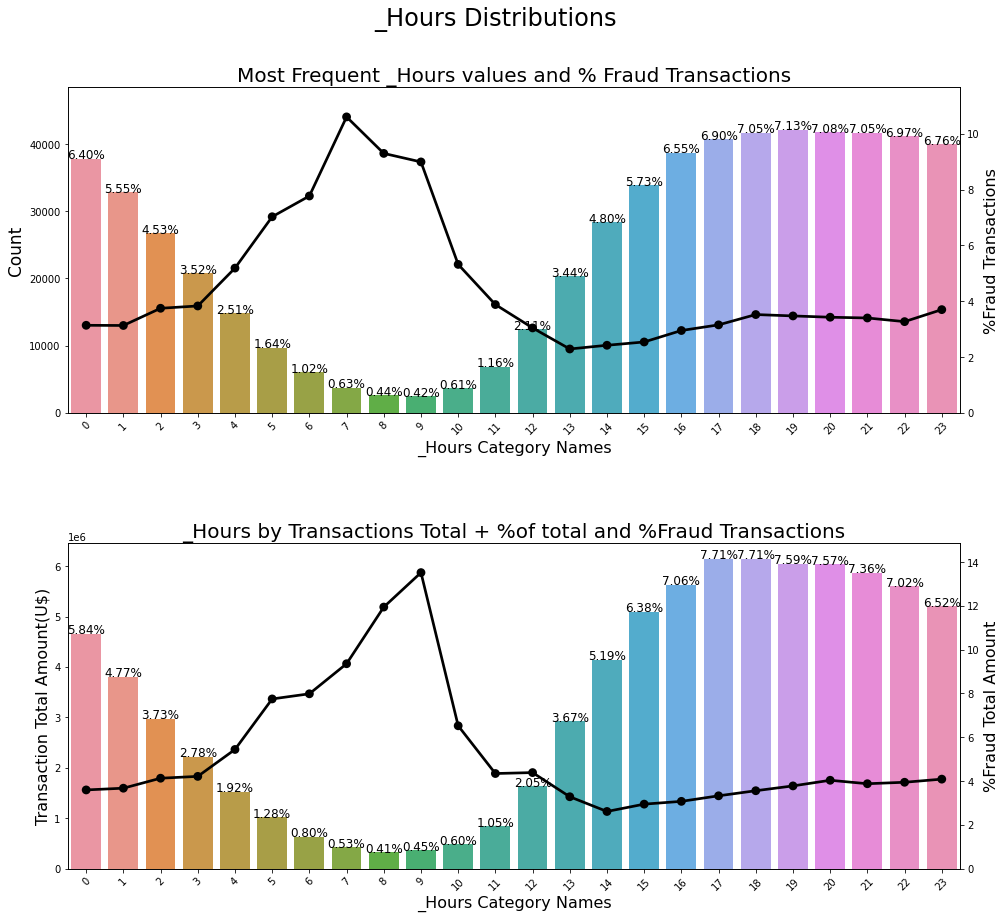

In [91]:
ploting_cnt_amt(df_trans, '_Hours')

## Transactions and Total Amount by each day

In [92]:
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']


dates_temp = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp['Date'], y=dates_temp.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[7]), name= 'Total Transactions')

# Below we will get the total amount sold
dates_temp_sum = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].sum().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.Date, line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1,], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

## FRAUD TRANSACTIONS BY DATE
- Visualizing only Fraud Transactions by Date

In [93]:
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

tmp_amt = df_trans.groupby([df_trans.Date.dt.date, 'isFraud'])['TransactionAmt'].sum().reset_index()
tmp_trans = df_trans.groupby([df_trans.Date.dt.date, 'isFraud'])['TransactionAmt'].count().reset_index()

tmp_trans_fraud = tmp_trans[tmp_trans['isFraud'] == 1]
tmp_amt_fraud = tmp_amt[tmp_amt['isFraud'] == 1]

dates_temp = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=tmp_trans_fraud['Date'], y=tmp_trans_fraud.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[1]), name= 'Fraud Transactions')

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=tmp_amt_fraud.Date, line = dict(color = color_op[7]), name="Fraud Amount",
                    y=tmp_amt_fraud['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "FRAUD TRANSACTIONS - Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

# Features [id_12 to id_38]
- categorical features in training identity dataset

In [94]:
df_id[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

id_12          id_13         id_14   id_15   id_16          id_17  \
count     144233  127320.000000  80044.000000  140985  129340  139369.000000   
unique         2            NaN           NaN       3       2            NaN   
top     NotFound            NaN           NaN   Found   Found            NaN   
freq      123025            NaN           NaN   67728   66324            NaN   
mean         NaN      48.053071   -344.507146     NaN     NaN     189.451377   
std          NaN      11.774858     93.695502     NaN     NaN      30.375360   
min          NaN      10.000000   -660.000000     NaN     NaN     100.000000   
25%          NaN      49.000000   -360.000000     NaN     NaN     166.000000   
50%          NaN      52.000000   -300.000000     NaN     NaN     166.000000   
75%          NaN      52.000000   -300.000000     NaN     NaN     225.000000   
max          NaN      64.000000    720.000000     NaN     NaN     229.000000   

               id_18          id_19          id_20        id_21  ...   id_29  \
count   45113.000000  139318.000000  139261.000000  5159.000000  ...  140978   
unique           NaN            NaN            NaN          NaN  ...       2   
top              NaN            NaN            NaN          NaN  ...   Found   
freq             NaN            NaN            NaN          NaN  ...   74926   
mean       14.237337     353.128174     403.882666   368.269820  ...     NaN   
std         1.561302     141.095343     152.160327   198.847038  ...     NaN   
min        10.000000     100.000000     100.000000   100.000000  ...     NaN   
25%        13.000000     266.000000     256.000000   252.000000  ...     NaN   
50%        15.000000     341.000000     472.000000   252.000000  ...     NaN   
75%        15.000000     427.000000     533.000000   486.500000  ...     NaN   
max        29.000000     671.000000     661.000000   854.000000  ...     NaN   

             id_30        id_31         id_32      id_33           id_34  \
count        77565       140282  77586.000000      73289           77805   
unique          75          130           NaN        260               4   
top     Windows 10  chrome 63.0           NaN  1920x1080  match_status:2   
freq         21155        22000           NaN      16874           60011   
mean           NaN          NaN     26.508597        NaN             NaN   
std            NaN          NaN      3.737502        NaN             NaN   
min            NaN          NaN      0.000000        NaN             NaN   
25%            NaN          NaN     24.000000        NaN             NaN   
50%            NaN          NaN     24.000000        NaN             NaN   
75%            NaN          NaN     32.000000        NaN             NaN   
max            NaN          NaN     32.000000        NaN             NaN   

         id_35   id_36   id_37   id_38  
count   140985  140985  140985  140985  
unique       2       2       2       2  
top          T       F       T       F  
freq     77814  134066  110452   73922  
mean       NaN     NaN     NaN     NaN  
std        NaN     NaN     NaN     NaN  
min        NaN     NaN     NaN     NaN  
25%        NaN     NaN     NaN     NaN  
50%        NaN     NaN     NaN     NaN  
75%        NaN     NaN     NaN     NaN  
max        NaN     NaN     NaN     NaN  

[11 rows x 27 columns]

In [95]:
df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True)

In [96]:
df_train

TransactionID_x  isFraud  TransactionDT  TransactionAmt ProductCD  \
0               2987000        0          86400           68.50         W   
1               2987001        0          86401           29.00         W   
2               2987002        0          86469           59.00         W   
3               2987003        0          86499           50.00         W   
4               2987004        0          86506           50.00         H   
...                 ...      ...            ...             ...       ...   
590535          3577535        0       15811047           49.00         W   
590536          3577536        0       15811049           39.50         W   
590537          3577537        0       15811079           30.95         W   
590538          3577538        0       15811088          117.00         W   
590539          3577539        0       15811131          279.95         W   

        card1  card2  card3       card4   card5  ...                id_31  \
0       13926    NaN  150.0    discover  Others  ...  samsung browser 6.2   
1        2755  404.0  150.0  mastercard   102.0  ...   mobile safari 11.0   
2        4663  490.0  150.0        visa   166.0  ...          chrome 62.0   
3       18132  567.0  150.0  mastercard   117.0  ...          chrome 62.0   
4        4497  514.0  150.0  mastercard   102.0  ...          chrome 62.0   
...       ...    ...    ...         ...     ...  ...                  ...   
590535   6550    NaN  150.0        visa   226.0  ...                  NaN   
590536  10444  225.0  150.0  mastercard   224.0  ...                  NaN   
590537  12037  595.0  150.0  mastercard   224.0  ...                  NaN   
590538   7826  481.0  150.0  mastercard   224.0  ...                  NaN   
590539  15066  170.0  150.0  mastercard   102.0  ...                  NaN   

       id_32      id_33           id_34  id_35 id_36 id_37 id_38 DeviceType  \
0       32.0  2220x1080  match_status:2      T     F     T     T     mobile   
1       32.0   1334x750  match_status:1      T     F     F     T     mobile   
2        NaN        NaN             NaN      F     F     T     T    desktop   
3        NaN        NaN             NaN      F     F     T     T    desktop   
4       24.0   1280x800  match_status:2      T     F     T     T    desktop   
...      ...        ...             ...    ...   ...   ...   ...        ...   
590535   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
590536   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
590537   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
590538   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   
590539   NaN        NaN             NaN    NaN   NaN   NaN   NaN        NaN   

                           DeviceInfo  
0       SAMSUNG SM-G892A Build/NRD90M  
1                          iOS Device  
2                             Windows  
3                                 NaN  
4                               MacOS  
...                               ...  
590535                            NaN  
590536                            NaN  
590537                            NaN  
590538                            NaN  
590539                            NaN  

[590540 rows x 439 columns]

In [97]:
def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
    g3.set_xlabel("ProductCD Name", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

## Ploting columns with few unique values

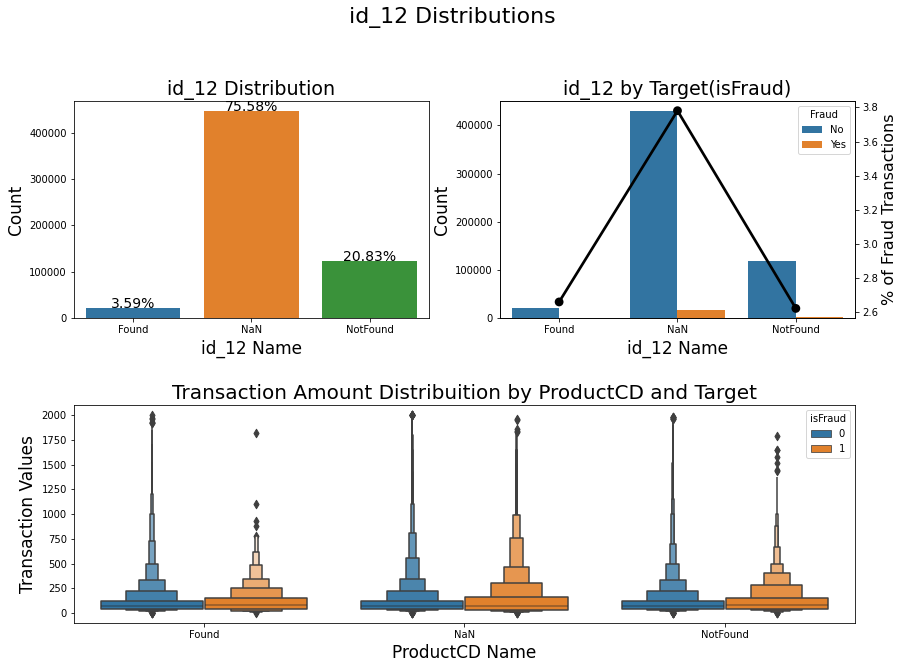

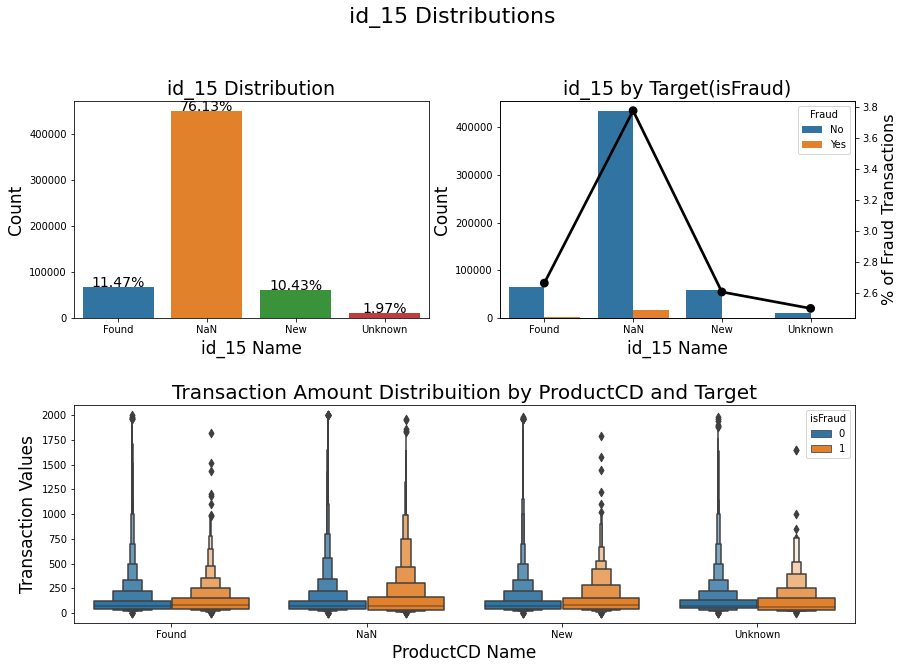

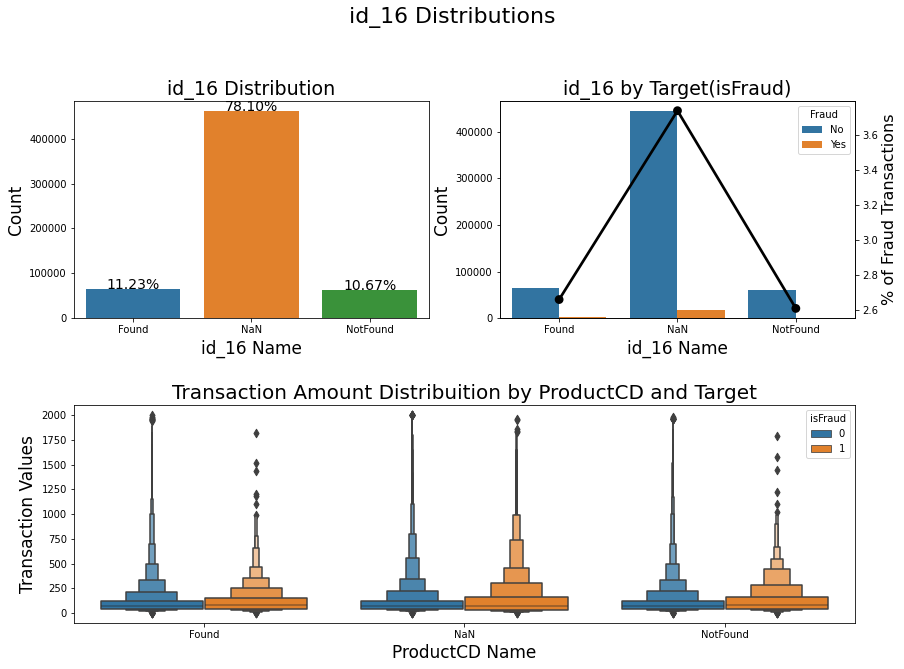

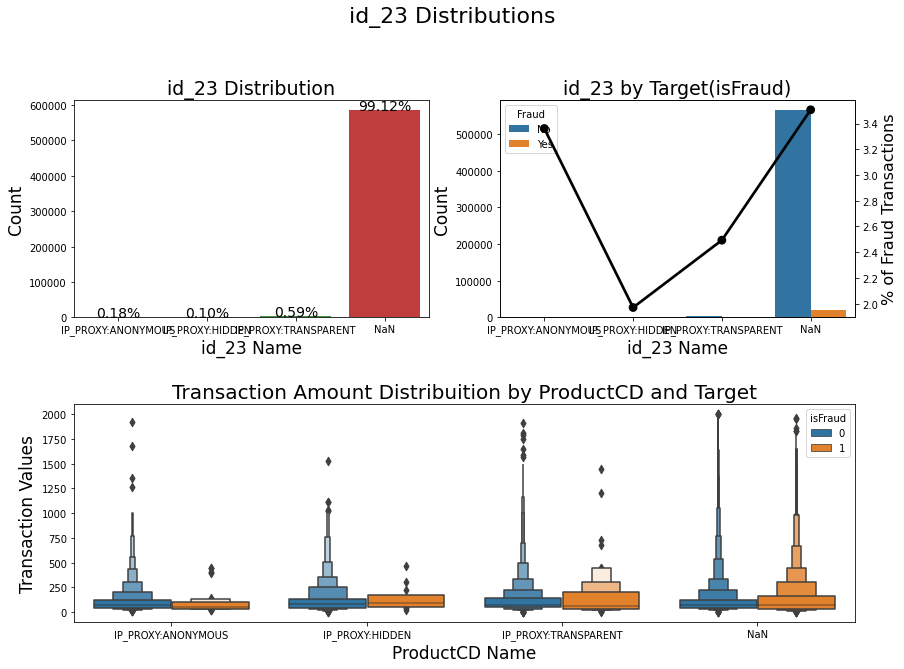

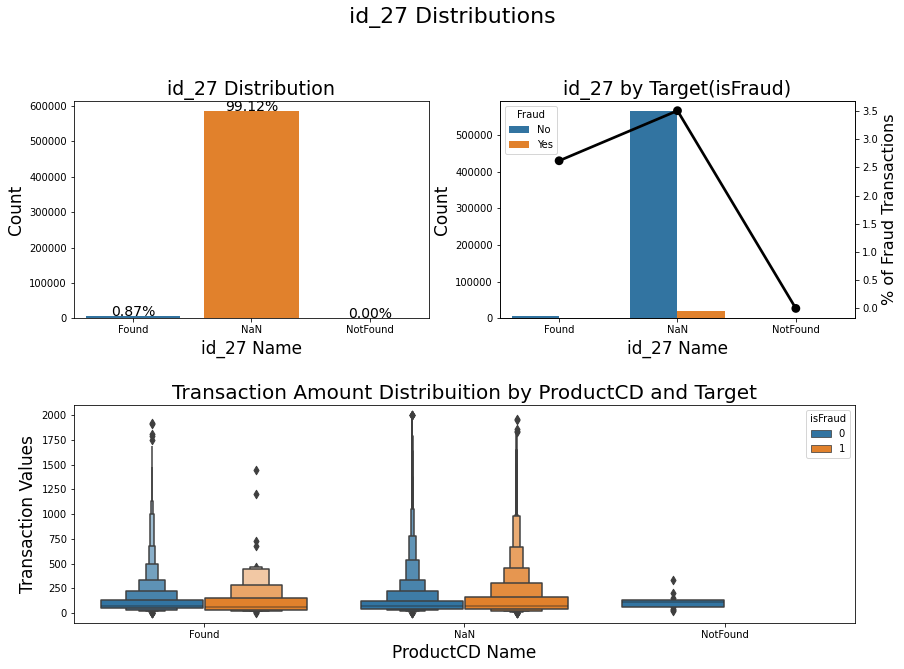

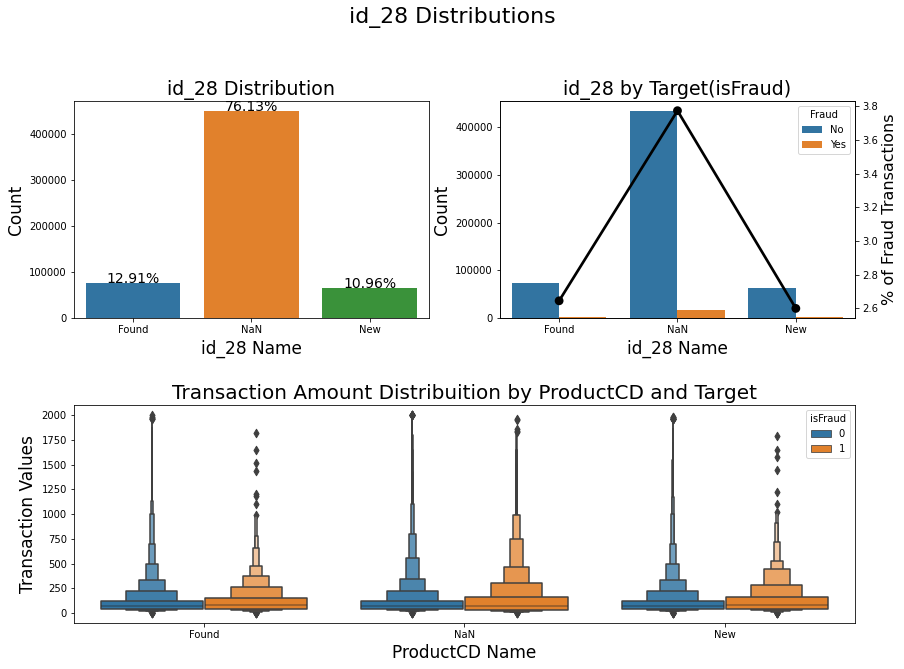

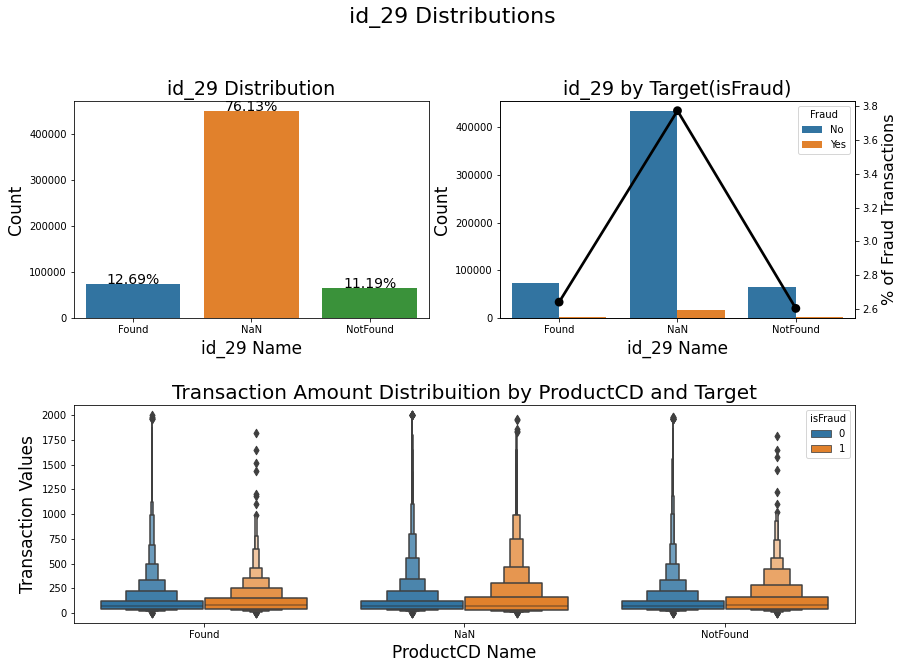

In [98]:
for col in ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29']:
    df_train[col] = df_train[col].fillna('NaN')
    cat_feat_ploting(df_train, col)

## Id 30

In [99]:
df_train.loc[df_train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_train.loc[df_train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_train.loc[df_train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df_train.loc[df_train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df_train['id_30'].fillna("NAN", inplace=True)

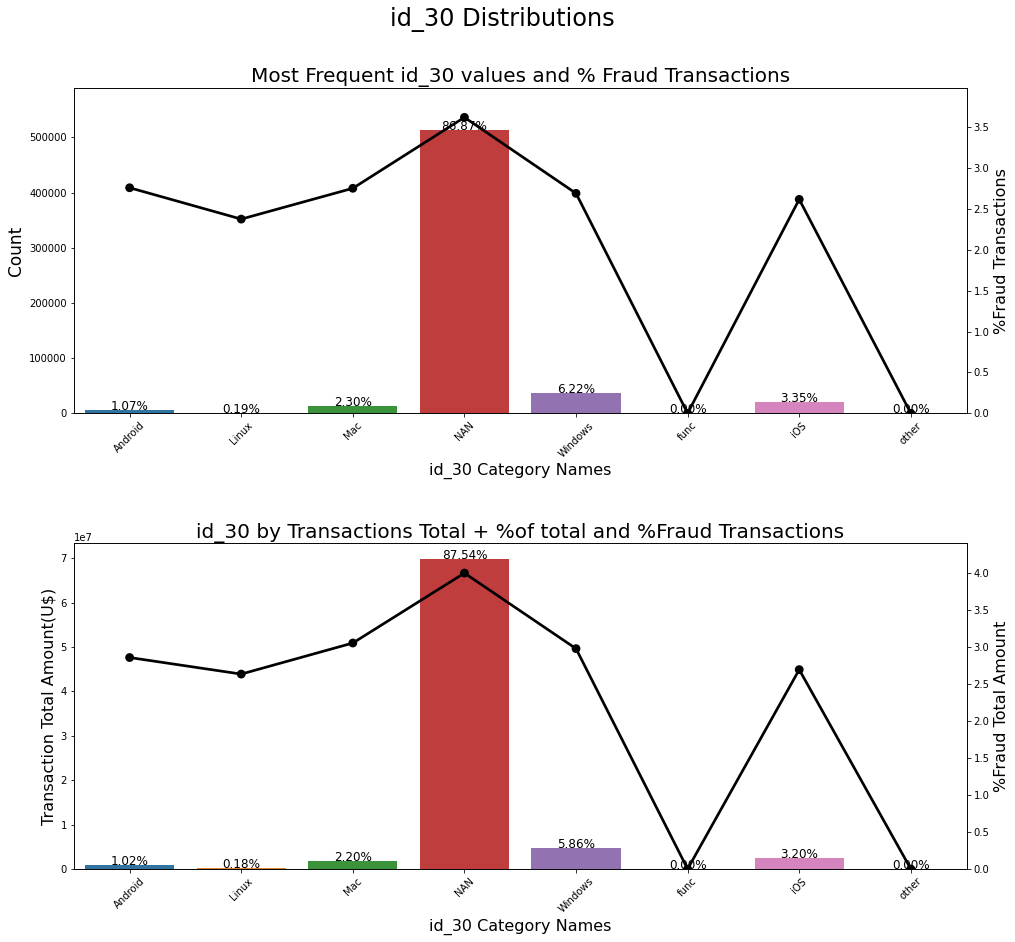

In [100]:
ploting_cnt_amt(df_train, 'id_30')

## Id 31

In [101]:
df_train.loc[df_train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
df_train.loc[df_train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
df_train.loc[df_train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
df_train.loc[df_train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
df_train.loc[df_train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
df_train.loc[df_train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
df_train.loc[df_train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
df_train['id_31'].fillna("NAN", inplace=True)
df_train.loc[df_train.id_31.isin(df_train.id_31.value_counts()[df_train.id_31.value_counts() < 200].index), 'id_31'] = "Others"

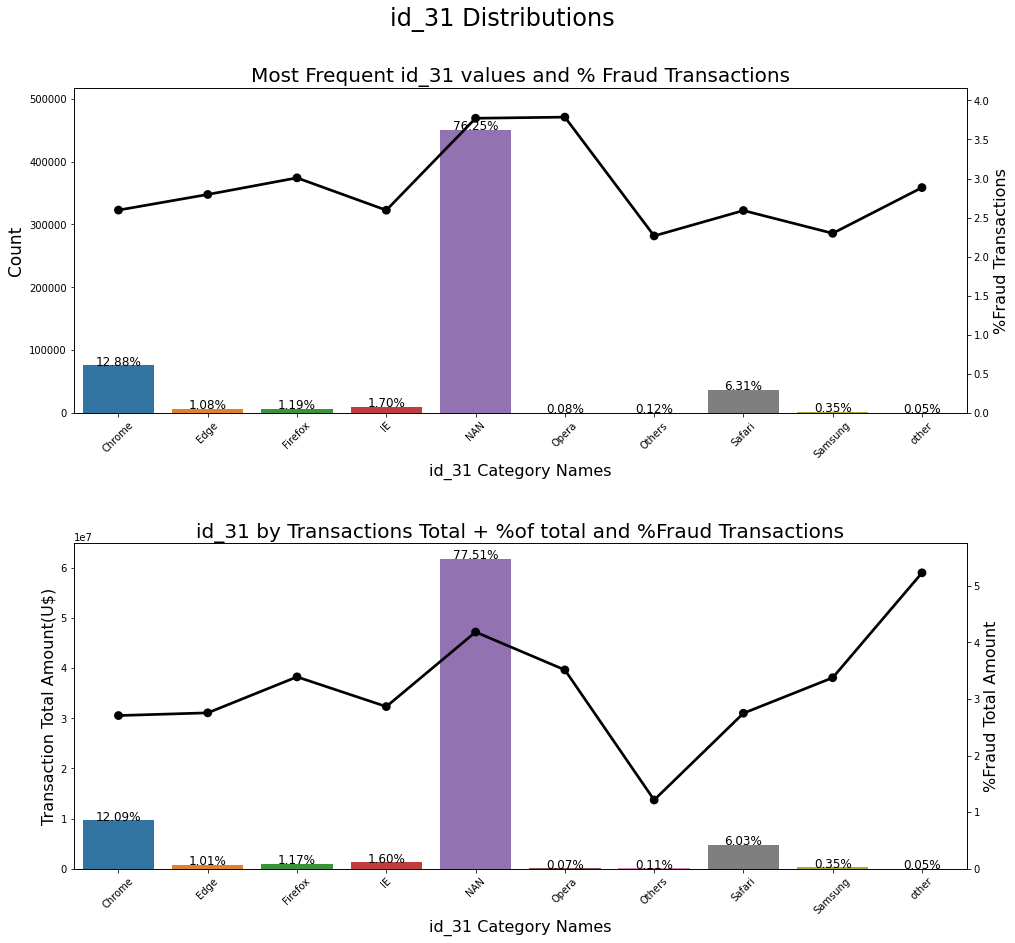

In [102]:
ploting_cnt_amt(df_train, 'id_31')

## Modelling 
To start simple, I will start using as base the kernels below: <br>
https://www.kaggle.com/artkulak/ieee-fraud-simple-baseline-0-9383-lb - (@artkulak - Art) <br>
https://www.kaggle.com/artgor/eda-and-models - (@artgor - Andrew Lukyanenko)



In [103]:
df_id = pd.read_csv("/content/drive/MyDrive/IEEE_Fraud_Detection/ieee-fraud-detection/train_identity.csv")
df_trans = pd.read_csv("/content/drive/MyDrive/IEEE_Fraud_Detection/ieee-fraud-detection/train_transaction.csv")

df_test_trans = pd.read_csv('/content/drive/MyDrive/IEEE_Fraud_Detection/ieee-fraud-detection/test_transaction.csv')
df_test_id = pd.read_csv('/content/drive/MyDrive/IEEE_Fraud_Detection/ieee-fraud-detection/test_identity.csv')

sample_submission = pd.read_csv('/content/drive/MyDrive/IEEE_Fraud_Detection/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

df_train = df_trans.merge(df_id, how='left', on='TransactionID')
df_test = df_test_trans.merge(df_test_id, how='left', on='TransactionID')

print(df_train.shape)
print(df_test.shape)

# y_train = df_train['isFraud'].copy()
del df_trans, df_id, df_test_trans, df_test_id


(590540, 434)
(506691, 433)


In [104]:
df_id = pd.read_csv("/content/drive/MyDrive/IEEE_Fraud_Detection/ieee-fraud-detection/train_identity.csv")


In [105]:
df_id

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  \
0             2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN   
1             2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN   
2             2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN   
3             2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN   
4             2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN   
...               ...    ...       ...    ...    ...    ...    ...    ...   
144228        3577521  -15.0  145955.0    0.0    0.0    0.0    0.0    NaN   
144229        3577526   -5.0  172059.0    NaN    NaN    1.0   -5.0    NaN   
144230        3577529  -20.0  632381.0    NaN    NaN   -1.0  -36.0    NaN   
144231        3577531   -5.0   55528.0    0.0    0.0    0.0   -7.0    NaN   
144232        3577534  -45.0  339406.0    NaN    NaN  -10.0 -100.0    NaN   

        id_08  id_09  ...                    id_31  id_32      id_33  \
0         NaN    NaN  ...      samsung browser 6.2   32.0  2220x1080   
1         NaN    NaN  ...       mobile safari 11.0   32.0   1334x750   
2         NaN    0.0  ...              chrome 62.0    NaN        NaN   
3         NaN    NaN  ...              chrome 62.0    NaN        NaN   
4         NaN    0.0  ...              chrome 62.0   24.0   1280x800   
...       ...    ...  ...                      ...    ...        ...   
144228    NaN    0.0  ...  chrome 66.0 for android    NaN        NaN   
144229    NaN    NaN  ...  chrome 55.0 for android   32.0    855x480   
144230    NaN    NaN  ...  chrome 65.0 for android    NaN        NaN   
144231    NaN    0.0  ...              chrome 66.0   24.0  2560x1600   
144232    NaN    NaN  ...  chrome 66.0 for android    NaN        NaN   

                 id_34  id_35 id_36 id_37  id_38  DeviceType  \
0       match_status:2      T     F     T      T      mobile   
1       match_status:1      T     F     F      T      mobile   
2                  NaN      F     F     T      T     desktop   
3                  NaN      F     F     T      T     desktop   
4       match_status:2      T     F     T      T     desktop   
...                ...    ...   ...   ...    ...         ...   
144228             NaN      F     F     T      F      mobile   
144229  match_status:2      T     F     T      F      mobile   
144230             NaN      F     F     T      F      mobile   
144231  match_status:2      T     F     T      F     desktop   
144232             NaN      F     F     T      F      mobile   

                                DeviceInfo  
0            SAMSUNG SM-G892A Build/NRD90M  
1                               iOS Device  
2                                  Windows  
3                                      NaN  
4                                    MacOS  
...                                    ...  
144228             F3111 Build/33.3.A.1.97  
144229                 A574BL Build/NMF26F  
144230  Moto E (4) Plus Build/NMA26.42-152  
144231                               MacOS  
144232         RNE-L03 Build/HUAWEIRNE-L03  

[144233 rows x 41 columns]

# reducing memory usage

In [106]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


# Mapping emails

In [107]:

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

<ipython-input-107-a84657de590e>:25: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-107-a84657de590e>:26: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-107-a84657de590e>:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-107-a84657de590e>:29: PerformanceW

In [108]:
df_train['id_02']

0             NaN
1             NaN
2             NaN
3             NaN
4         70787.0
           ...   
590535        NaN
590536        NaN
590537        NaN
590538        NaN
590539        NaN
Name: id_02, Length: 590540, dtype: float32

In [109]:
df_test

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224       31.953125         W  10409  111.0   
1             3663550       18403263       49.000000         W   4272  111.0   
2             3663551       18403310      171.000000         W   4476  574.0   
3             3663552       18403310      285.000000         W  10989  360.0   
4             3663553       18403317       67.937500         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279       94.687500         C  13832  375.0   
506687        4170236       34214287       12.171875         C   3154  408.0   
506688        4170237       34214326       49.000000         W  16661  490.0   
506689        4170238       34214337      202.000000         W  16621  516.0   
506690        4170239       34214345       24.343750         C   5713  168.0   

        card3       card4  card5   card6  ...  id-35  id-36  id-37  id-38  \
0       150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
1       150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
2       150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
3       150.0        visa  166.0   debit  ...    NaN    NaN    NaN    NaN   
4       150.0  mastercard  117.0   debit  ...    NaN    NaN    NaN    NaN   
...       ...         ...    ...     ...  ...    ...    ...    ...    ...   
506686  185.0  mastercard  224.0   debit  ...    NaN    NaN    NaN    NaN   
506687  185.0  mastercard  224.0   debit  ...      F      F      T      F   
506688  150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
506689  150.0  mastercard  224.0   debit  ...    NaN    NaN    NaN    NaN   
506690  144.0        visa  147.0  credit  ...      F      F      T      F   

       DeviceType                   DeviceInfo  P_emaildomain_bin  \
0             NaN                          NaN             google   
1             NaN                          NaN                aol   
2             NaN                          NaN          microsoft   
3             NaN                          NaN             google   
4             NaN                          NaN             google   
...           ...                          ...                ...   
506686        NaN                          NaN             google   
506687     mobile  ALE-L23 Build/HuaweiALE-L23          microsoft   
506688        NaN                          NaN          microsoft   
506689        NaN                          NaN          microsoft   
506690     mobile                      SAMSUNG          microsoft   

        P_emaildomain_suffix  R_emaildomain_bin  R_emaildomain_suffix  
0                        com                NaN                   nan  
1                        com                NaN                   nan  
2                        com                NaN                   nan  
3                        com                NaN                   nan  
4                        com                NaN                   nan  
...                      ...                ...                   ...  
506686                   com             google                   com  
506687                   com          microsoft                   com  
506688                   com                NaN                   nan  
506689                   com                NaN                   nan  
506690                   com          microsoft                   com  

[506691 rows x 437 columns]

In [110]:
summary = pd.DataFrame(df_test.dtypes,columns=['dtypes'])

In [111]:
summary

dtypes
TransactionID           int32
TransactionDT           int32
TransactionAmt        float16
ProductCD              object
card1                   int16
...                       ...
DeviceInfo             object
P_emaildomain_bin      object
P_emaildomain_suffix   object
R_emaildomain_bin      object
R_emaildomain_suffix   object

[437 rows x 1 columns]

In [112]:
df_train.drop('id_01', axis=1)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400       68.500000         W   
1             2987001        0          86401       29.000000         W   
2             2987002        0          86469       59.000000         W   
3             2987003        0          86499       50.000000         W   
4             2987004        0          86506       50.000000         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047       49.000000         W   
590536        3577536        0       15811049       39.500000         W   
590537        3577537        0       15811079       30.953125         W   
590538        3577538        0       15811088      117.000000         W   
590539        3577539        0       15811131      280.000000         W   

        card1  card2  card3       card4  card5  ... id_35  id_36  id_37  \
0       13926    NaN  150.0    discover  142.0  ...   NaN    NaN    NaN   
1        2755  404.0  150.0  mastercard  102.0  ...   NaN    NaN    NaN   
2        4663  490.0  150.0        visa  166.0  ...   NaN    NaN    NaN   
3       18132  567.0  150.0  mastercard  117.0  ...   NaN    NaN    NaN   
4        4497  514.0  150.0  mastercard  102.0  ...     T      F      T   
...       ...    ...    ...         ...    ...  ...   ...    ...    ...   
590535   6550    NaN  150.0        visa  226.0  ...   NaN    NaN    NaN   
590536  10444  225.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
590537  12037  595.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
590538   7826  481.0  150.0  mastercard  224.0  ...   NaN    NaN    NaN   
590539  15066  170.0  150.0  mastercard  102.0  ...   NaN    NaN    NaN   

        id_38  DeviceType                     DeviceInfo P_emaildomain_bin  \
0         NaN         NaN                            NaN               NaN   
1         NaN         NaN                            NaN            google   
2         NaN         NaN                            NaN         microsoft   
3         NaN         NaN                            NaN             yahoo   
4           T      mobile  SAMSUNG SM-G892A Build/NRD90M            google   
...       ...         ...                            ...               ...   
590535    NaN         NaN                            NaN               NaN   
590536    NaN         NaN                            NaN            google   
590537    NaN         NaN                            NaN            google   
590538    NaN         NaN                            NaN               aol   
590539    NaN         NaN                            NaN            google   

        P_emaildomain_suffix  R_emaildomain_bin  R_emaildomain_suffix  
0                        nan                NaN                   nan  
1                        com                NaN                   nan  
2                        com                NaN                   nan  
3                        com                NaN                   nan  
4                        com                NaN                   nan  
...                      ...                ...                   ...  
590535                   nan                NaN                   nan  
590536                   com                NaN                   nan  
590537                   com                NaN                   nan  
590538                   com                NaN                   nan  
590539                   com                NaN                   nan  

[590540 rows x 437 columns]

In [122]:
df_train['id_01'].dtype

dtype('float16')

In [121]:
df_test['id-01'].dtype

dtype('float16')

In [116]:
df_train.shape

(590540, 438)

In [124]:
df_test.shape

(506691, 437)

In [126]:
df_train['id_12'].dtype

dtype('O')

In [127]:
df_train['id_12']

0              NaN
1              NaN
2              NaN
3              NaN
4         NotFound
            ...   
590535         NaN
590536         NaN
590537         NaN
590538         NaN
590539         NaN
Name: id_12, Length: 590540, dtype: object

# Encoding categorical features

In [129]:
# Label Encoding
for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        

In [131]:
for f in df_test.columns:
  if df_test[f].dtype=='object':
    lbl1 = preprocessing.LabelEncoder()
    lbl1.fit(list(df_test[f].values))
    df_test[f] = lbl1.transform(list(df_test[f].values))

# Some feature engineering

In [132]:
df_train['Trans_min_mean'] = df_train['TransactionAmt'] - df_train['TransactionAmt'].mean()
df_train['Trans_min_std'] = df_train['Trans_min_mean'] / df_train['TransactionAmt'].std()
df_test['Trans_min_mean'] = df_test['TransactionAmt'] - df_test['TransactionAmt'].mean()
df_test['Trans_min_std'] = df_test['Trans_min_mean'] / df_test['TransactionAmt'].std()

<ipython-input-132-c38dc4251dde>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-132-c38dc4251dde>:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [134]:
df_train

TransactionID  isFraud  TransactionDT  TransactionAmt  ProductCD  \
0             2987000        0          86400       68.500000          4   
1             2987001        0          86401       29.000000          4   
2             2987002        0          86469       59.000000          4   
3             2987003        0          86499       50.000000          4   
4             2987004        0          86506       50.000000          1   
...               ...      ...            ...             ...        ...   
590535        3577535        0       15811047       49.000000          4   
590536        3577536        0       15811049       39.500000          4   
590537        3577537        0       15811079       30.953125          4   
590538        3577538        0       15811088      117.000000          4   
590539        3577539        0       15811131      280.000000          4   

        card1  card2  card3  card4  card5  ...  id_37  id_38  DeviceType  \
0       13926    NaN  150.0      1  142.0  ...      2      2           2   
1        2755  404.0  150.0      2  102.0  ...      2      2           2   
2        4663  490.0  150.0      4  166.0  ...      2      2           2   
3       18132  567.0  150.0      2  117.0  ...      2      2           2   
4        4497  514.0  150.0      2  102.0  ...      1      1           1   
...       ...    ...    ...    ...    ...  ...    ...    ...         ...   
590535   6550    NaN  150.0      4  226.0  ...      2      2           2   
590536  10444  225.0  150.0      2  224.0  ...      2      2           2   
590537  12037  595.0  150.0      2  224.0  ...      2      2           2   
590538   7826  481.0  150.0      2  224.0  ...      2      2           2   
590539  15066  170.0  150.0      2  102.0  ...      2      2           2   

        DeviceInfo  P_emaildomain_bin  P_emaildomain_suffix  \
0             1742                  6                     6   
1             1742                  4                     0   
2             1742                  5                     0   
3             1742                  9                     0   
4              954                  4                     0   
...            ...                ...                   ...   
590535        1742                  6                     6   
590536        1742                  4                     0   
590537        1742                  4                     0   
590538        1742                  0                     0   
590539        1742                  4                     0   

        R_emaildomain_bin  R_emaildomain_suffix  Trans_min_mean  Trans_min_std  
0                       6                     6             NaN            NaN  
1                       6                     6             NaN            NaN  
2                       6                     6             NaN            NaN  
3                       6                     6             NaN            NaN  
4                       6                     6             NaN            NaN  
...                   ...                   ...             ...            ...  
590535                  6                     6             NaN            NaN  
590536                  6                     6             NaN            NaN  
590537                  6                     6             NaN            NaN  
590538                  6                     6             NaN            NaN  
590539                  6                     6             NaN            NaN  

[590540 rows x 440 columns]

In [135]:
df_train['TransactionAmt_to_mean_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_mean_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_std_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('std')
df_train['TransactionAmt_to_std_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('std')

df_test['TransactionAmt_to_mean_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_mean_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_std_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('std')
df_test['TransactionAmt_to_std_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('std')

<ipython-input-135-211ec1243044>:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-135-211ec1243044>:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-135-211ec1243044>:8: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-135-211ec1243044>:9: PerformanceWarni

In [139]:
df_train

TransactionID  isFraud  TransactionDT  TransactionAmt  ProductCD  \
0             2987000        0          86400        4.226562          4   
1             2987001        0          86401        3.367188          4   
2             2987002        0          86469        4.078125          4   
3             2987003        0          86499        3.912109          4   
4             2987004        0          86506        3.912109          1   
...               ...      ...            ...             ...        ...   
590535        3577535        0       15811047        3.892578          4   
590536        3577536        0       15811049        3.675781          4   
590537        3577537        0       15811079        3.431641          4   
590538        3577538        0       15811088        4.761719          4   
590539        3577539        0       15811131        5.636719          4   

        card1  card2  card3  card4  card5  ...  P_emaildomain_bin  \
0       13926    NaN  150.0      1  142.0  ...                  6   
1        2755  404.0  150.0      2  102.0  ...                  4   
2        4663  490.0  150.0      4  166.0  ...                  5   
3       18132  567.0  150.0      2  117.0  ...                  9   
4        4497  514.0  150.0      2  102.0  ...                  4   
...       ...    ...    ...    ...    ...  ...                ...   
590535   6550    NaN  150.0      4  226.0  ...                  6   
590536  10444  225.0  150.0      2  224.0  ...                  4   
590537  12037  595.0  150.0      2  224.0  ...                  4   
590538   7826  481.0  150.0      2  224.0  ...                  0   
590539  15066  170.0  150.0      2  102.0  ...                  4   

        P_emaildomain_suffix  R_emaildomain_bin  R_emaildomain_suffix  \
0                          6                  6                     6   
1                          0                  6                     6   
2                          0                  6                     6   
3                          0                  6                     6   
4                          0                  6                     6   
...                      ...                ...                   ...   
590535                     6                  6                     6   
590536                     0                  6                     6   
590537                     0                  6                     6   
590538                     0                  6                     6   
590539                     0                  6                     6   

        Trans_min_mean  Trans_min_std  TransactionAmt_to_mean_card1  \
0                  NaN            NaN                      0.194580   
1                  NaN            NaN                      0.123779   
2                  NaN            NaN                      0.608398   
3                  NaN            NaN                      0.405029   
4                  NaN            NaN                      0.515625   
...                ...            ...                           ...   
590535             NaN            NaN                      0.505371   
590536             NaN            NaN                      0.163208   
590537             NaN            NaN                      0.258545   
590538             NaN            NaN                      0.953125   
590539             NaN            NaN                      1.333984   

        TransactionAmt_to_mean_card4  TransactionAmt_to_std_card1  \
0                           0.257812                     0.184560   
1                           0.219116                     0.063004   
2                           0.443115                     0.589226   
3                           0.377686                     0.259460   
4                           0.377686                     0.882898   
...                              ...                          ...   
590535                      0.368164                 

In [140]:
df_train['TransactionAmt'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log(df_test['TransactionAmt'])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



# Concating dfs to get PCA of V features

In [149]:
df_test['isFraud'] = 'test'
df = pd.concat([df_train, df_test], axis=0, sort=False )
df = df.reset_index()
df = df.drop('index', axis=1)

In [143]:
df = pd.concat([df_train, df_test], axis=0, sort=False )

In [145]:
df = df.reset_index()

In [146]:
df

index  TransactionID isFraud  TransactionDT  TransactionAmt  \
0             0        2987000       0          86400        1.441406   
1             1        2987001       0          86401        1.213867   
2             2        2987002       0          86469        1.405273   
3             3        2987003       0          86499        1.364258   
4             4        2987004       0          86506        1.364258   
...         ...            ...     ...            ...             ...   
1097226  506686        4170235    test       34214279        1.515625   
1097227  506687        4170236    test       34214287        0.916504   
1097228  506688        4170237    test       34214326        1.359375   
1097229  506689        4170238    test       34214337        1.668945   
1097230  506690        4170239    test       34214345        1.160156   

         ProductCD  card1  card2  card3  card4  ...  id-29  id-30  id-31  \
0                4  13926    NaN  150.0      1  ...    NaN    NaN    NaN   
1                4   2755  404.0  150.0      2  ...    NaN    NaN    NaN   
2                4   4663  490.0  150.0      4  ...    NaN    NaN    NaN   
3                4  18132  567.0  150.0      2  ...    NaN    NaN    NaN   
4                1   4497  514.0  150.0      2  ...    NaN    NaN    NaN   
...            ...    ...    ...    ...    ...  ...    ...    ...    ...   
1097226          0  13832  375.0  185.0      2  ...    2.0   85.0  107.0   
1097227          0   3154  408.0  185.0      2  ...    1.0   85.0    5.0   
1097228          4  16661  490.0  150.0      4  ...    2.0   85.0  107.0   
1097229          4  16621  516.0  150.0      2  ...    2.0   85.0  107.0   
1097230          0   5713  168.0  144.0      4  ...    0.0   85.0  134.0   

         id-32  id-33  id-34  id-35  id-36  id-37  id-38  
0          NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1          NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4          NaN    NaN    NaN    NaN    NaN    NaN    NaN  
...        ...    ...    ...    ...    ...    ...    ...  
1097226    NaN  390.0    2.0    2.0    2.0    2.0    2.0  
1097227    NaN  390.0    2.0    0.0    0.0    1.0    0.0  
1097228    NaN  390.0    2.0    2.0    2.0    2.0    2.0  
1097229    NaN  390.0    2.0    2.0    2.0    2.0    2.0  
1097230    NaN  390.0    2.0    0.0    0.0    1.0    0.0  

[1097231 rows x 483 columns]

In [ ]:
#In the below PCA function the columns that are transformed are added or merged to the original df. The original columns on which the PCA is applied is dropped. 

In [150]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

pandas.core.frame.DataFrame

In [203]:
mas_v = df_train.columns[55:394]

In [211]:
mas_v.dtype

dtype('O')

In [215]:
df

TransactionID isFraud  TransactionDT  TransactionAmt  ProductCD  \
0              2987000       0          86400        1.441406          4   
1              2987001       0          86401        1.213867          4   
2              2987002       0          86469        1.405273          4   
3              2987003       0          86499        1.364258          4   
4              2987004       0          86506        1.364258          1   
...                ...     ...            ...             ...        ...   
1097226        4170235    test       34214279        1.515625          0   
1097227        4170236    test       34214287        0.916504          0   
1097228        4170237    test       34214326        1.359375          4   
1097229        4170238    test       34214337        1.668945          4   
1097230        4170239    test       34214345        1.160156          0   

         card1  card2  card3  card4  card5  ...  PCA_V_20  PCA_V_21  PCA_V_22  \
0        13926    NaN  150.0      1  142.0  ...  0.014718 -0.013273  0.004701   
1         2755  404.0  150.0      2  102.0  ...  0.010932 -0.003939 -0.001608   
2         4663  490.0  150.0      4  166.0  ... -0.005266 -0.002108 -0.006021   
3        18132  567.0  150.0      2  117.0  ...  0.014880  0.024199 -0.001208   
4         4497  514.0  150.0      2  102.0  ...  0.013186  0.069690  0.024159   
...        ...    ...    ...    ...    ...  ...       ...       ...       ...   
1097226  13832  375.0  185.0      2  224.0  ...  0.017463  0.050910  0.070862   
1097227   3154  408.0  185.0      2  224.0  ... -0.011688 -0.021100  0.034644   
1097228  16661  490.0  150.0      4  226.0  ... -0.005289 -0.002104 -0.006040   
1097229  16621  516.0  150.0      2  224.0  ... -0.005289 -0.002104 -0.006040   
1097230   5713  168.0  144.0      4  147.0  ... -0.007426 -0.010994  0.030887   

         PCA_V_23  PCA_V_24  PCA_V_25  PCA_V_26  PCA_V_27  PCA_V_28  PCA_V_29  
0       -0.048879 -0.036919 -0.043064 -0.005949 -0.063126  0.007535 -0.050967  
1        0.017425  0.034295  0.037303  0.021167 -0.035243  0.004461  0.004146  
2       -0.001895 -0.000814 -0.000382 -0.007425 -0.000156 -0.015862 -0.000589  
3        0.033791  0.056927  0.032433  0.009062 -0.015615  0.049784  0.004035  
4        0.016620 -0.045462 -0.010748 -0.007404  0.007234 -0.030619  0.010906  
...           ...       ...       ...       ...       ...       ...       ...  
1097226 -0.026637 -0.010985 -0.054675  0.053590  0.001043  0.000947  0.041968  
1097227  0.006168  0.000525  0.002500  0.007618  0.005950  0.001538 -0.001950  
1097228 -0.001916 -0.000795 -0.000388 -0.007410 -0.000198 -0.015841 -0.000666  
1097229 -0.001916 -0.000795 -0.000388 -0.007410 -0.000198 -0.015841 -0.000666  
1097230 -0.016155  0.012485 -0.003854  0.017472  0.013451  0.007824 -0.006991  

[1097231 rows x 173 columns]

In [186]:
col = [f'{str(col)}' for col in mas_v]
print(col)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V1

# Getting PCA 

In [204]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

for col in mas_v:
  col = [f'{str(col)}' for col in mas_v]
  df[col] = df[col].fillna((df[col].min()))
  df[col] = (minmax_scale(df[col], feature_range=(0,1)))

    
df = PCA_change(df, mas_v, prefix='PCA_V_', n_components=30)

KeyError: ignored

In [157]:
df_train

TransactionID  isFraud  TransactionDT  TransactionAmt  ProductCD  \
0             2987000        0          86400        1.441406          4   
1             2987001        0          86401        1.213867          4   
2             2987002        0          86469        1.405273          4   
3             2987003        0          86499        1.364258          4   
4             2987004        0          86506        1.364258          1   
...               ...      ...            ...             ...        ...   
590535        3577535        0       15811047        1.359375          4   
590536        3577536        0       15811049        1.301758          4   
590537        3577537        0       15811079        1.233398          4   
590538        3577538        0       15811088        1.560547          4   
590539        3577539        0       15811131        1.729492          4   

        card1  card2  card3  card4  card5  ...  P_emaildomain_bin  \
0       13926    NaN  150.0      1  142.0  ...                  6   
1        2755  404.0  150.0      2  102.0  ...                  4   
2        4663  490.0  150.0      4  166.0  ...                  5   
3       18132  567.0  150.0      2  117.0  ...                  9   
4        4497  514.0  150.0      2  102.0  ...                  4   
...       ...    ...    ...    ...    ...  ...                ...   
590535   6550    NaN  150.0      4  226.0  ...                  6   
590536  10444  225.0  150.0      2  224.0  ...                  4   
590537  12037  595.0  150.0      2  224.0  ...                  4   
590538   7826  481.0  150.0      2  224.0  ...                  0   
590539  15066  170.0  150.0      2  102.0  ...                  4   

        P_emaildomain_suffix  R_emaildomain_bin  R_emaildomain_suffix  \
0                          6                  6                     6   
1                          0                  6                     6   
2                          0                  6                     6   
3                          0                  6                     6   
4                          0                  6                     6   
...                      ...                ...                   ...   
590535                     6                  6                     6   
590536                     0                  6                     6   
590537                     0                  6                     6   
590538                     0                  6                     6   
590539                     0                  6                     6   

        Trans_min_mean  Trans_min_std  TransactionAmt_to_mean_card1  \
0                  NaN            NaN                      0.194580   
1                  NaN            NaN                      0.123779   
2                  NaN            NaN                      0.608398   
3                  NaN            NaN                      0.405029   
4                  NaN            NaN                      0.515625   
...                ...            ...                           ...   
590535             NaN            NaN                      0.505371   
590536             NaN            NaN                      0.163208   
590537             NaN            NaN                      0.258545   
590538             NaN            NaN                      0.953125   
590539             NaN            NaN                      1.333984   

        TransactionAmt_to_mean_card4  TransactionAmt_to_std_card1  \
0                           0.257812                     0.184560   
1                           0.219116                     0.063004   
2                           0.443115                     0.589226   
3                           0.377686                     0.259460   
4                           0.377686                     0.882898   
...                              ...                          ...   
590535                      0.368164                 

In [ ]:
df = reduce_mem_usage(df)

# Seting train and test back

In [219]:
df_train, df_test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud', axis=1)

In [220]:
df_train.shape

(590540, 173)

In [221]:
y_train = df_train.sort_values('TransactionDT')['isFraud']

In [223]:
y_train.shape

(590540,)

# Seting X and y

In [224]:
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 
                                                      'TransactionDT', 
                                                      #'Card_ID'
                                                     ],
                                                     axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud'].astype(bool)

X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT',
                                                    #'Card_ID'
                                                   ], 
                                                   axis=1)
del df_train
df_test = df_test[["TransactionDT"]]

# Defining the HyperOpt function with parameters space and model

In [ ]:
#taking out the best parameters using cross validation

In [225]:
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 10
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(sample_submission.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}


# Running the optimizer

In [227]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=3)

# Print best parameters
best_params = space_eval(space, best)


############## New Run ################
params = {'max_depth': 19, 'gamma': '0.028', 'subsample': '0.90', 'reg_alpha': '0.298', 'reg_lambda': '0.359', 'learning_rate': '0.177', 'num_leaves': '110.000', 'colsample_bytree': '0.670', 'min_child_samples': '220.000', 'feature_fraction': '0.580', 'bagging_fraction': '0.790'}
1 CV - score: 0.9009
2 CV - score: 0.8956
3 CV - score: 0.9103
4 CV - score: 0.9242
5 CV - score: 0.9096
6 CV - score: 0.8994
7 CV - score: 0.9339
8 CV - score: 0.9261
9 CV - score: 0.9291
10 CV - score: 0.9216
Total Time Run: 6.21
Mean ROC_AUC: 0.9150660102952864

############## New Run ################
params = {'max_depth': 15, 'gamma': '0.284', 'subsample': '0.40', 'reg_alpha': '0.028', 'reg_lambda': '0.011', 'learning_rate': '0.072', 'num_leaves': '50.000', 'colsample_bytree': '0.515', 'min_child_samples': '180.000', 'feature_fraction': '0.569', 'bagging_fraction': '0.633'}
1 CV - score: 0.8967
2 CV - score: 0.8865
3 CV - score: 0.9045
4 CV - score: 0.9132
5 CV - s

# Best parameters

In [228]:
print("BEST PARAMS: ", best_params)

best_params['max_depth'] = int(best_params['max_depth'])

BEST PARAMS:  {'bagging_fraction': 0.7895626504386235, 'colsample_bytree': 0.670313814484055, 'feature_fraction': 0.5796520300397416, 'gamma': 0.028103981293714032, 'learning_rate': 0.1765489855687271, 'max_depth': 19.0, 'min_child_samples': 220, 'num_leaves': 110, 'reg_alpha': 0.29842925960444383, 'reg_lambda': 0.35935839808209147, 'subsample': 0.9}


# Trainning and Predicting with best Parameters

## Predicting X test

In [232]:
X_test

TransactionID  TransactionAmt  ProductCD  card1  card2  card3  card4  \
590540         3663549        1.242188          4  10409  111.0  150.0      4   
590541         3663550        1.359375          4   4272  111.0  150.0      4   
590542         3663551        1.636719          4   4476  574.0  150.0      4   
590543         3663552        1.732422          4  10989  360.0  150.0      4   
590544         3663553        1.439453          4  18018  452.0  150.0      2   
...                ...             ...        ...    ...    ...    ...    ...   
1097226        4170235        1.515625          0  13832  375.0  185.0      2   
1097227        4170236        0.916504          0   3154  408.0  185.0      2   
1097228        4170237        1.359375          4  16661  490.0  150.0      4   
1097229        4170238        1.668945          4  16621  516.0  150.0      2   
1097230        4170239        1.160156          0   5713  168.0  144.0      4   

         card5  card6  addr1  ...  PCA_V_20  PCA_V_21  PCA_V_22  PCA_V_23  \
590540   226.0      2  170.0  ... -0.029707  0.002822 -0.007198  0.022594   
590541   226.0      2  299.0  ...  0.039429 -0.019122 -0.000441 -0.003241   
590542   226.0      2  472.0  ...  0.090673 -0.038706  0.001838  0.007520   
590543   166.0      2  205.0  ... -0.051987  0.023717  0.000272  0.040893   
590544   117.0      2  264.0  ...  0.011790  0.002117  0.008330  0.008169   
...        ...    ...    ...  ...       ...       ...       ...       ...   
1097226  224.0      2  284.0  ...  0.017463  0.050910  0.070862 -0.026637   
1097227  224.0      2    NaN  ... -0.011688 -0.021100  0.034644  0.006168   
1097228  226.0      2  327.0  ... -0.005289 -0.002104 -0.006040 -0.001916   
1097229  224.0      2  177.0  ... -0.005289 -0.002104 -0.006040 -0.001916   
1097230  147.0      1    NaN  ... -0.007426 -0.010994  0.030887 -0.016155   

         PCA_V_24  PCA_V_25  PCA_V_26  PCA_V_27  PCA_V_28  PCA_V_29  
590540  -0.082520  0.104348  0.075074  0.003296  0.065879  0.081384  
590541   0.018732 -0.010038 -0.009840  0.000649 -0.000282 -0.011197  
590542   0.005777  0.010688 -0.007391  0.032823  0.006100  0.005565  
590543   0.003276 -0.007881  0.016105 -0.001828  0.021604 -0.009240  
590544  -0.000609  0.000101  0.012466 -0.023077 -0.037113  0.042061  
...           ...       ...       ...       ...       ...       ...  
1097226 -0.010985 -0.054675  0.053590  0.001043  0.000947  0.041968  
1097227  0.000525  0.002500  0.007618  0.005950  0.001538 -0.001950  
1097228 -0.000795 -0.000388 -0.007410 -0.000198 -0.015841 -0.000666  
1097229 -0.000795 -0.000388 -0.007410 -0.000198 -0.015841 -0.000666  
1097230  0.012485 -0.003854  0.017472  0.013451  0.007824 -0.006991  

[506691 rows x 171 columns]

In [239]:
clf = xgb.XGBClassifier(
    n_estimators=300,
    **best_params,
    tree_method='gpu_hist'
)

clf.fit(X_train, y_train)

y_preds = clf.predict_proba(X_test)[:,1] 

In [243]:
y_train

0         False
1         False
2         False
3         False
4         False
          ...  
590535    False
590536    False
590537    False
590538    False
590539    False
Name: isFraud, Length: 590540, dtype: bool

In [240]:
y_preds

array([5.9571576e-05, 7.2077826e-05, 2.6910484e-04, ..., 2.1851685e-05,
       8.3058789e-05, 2.5687981e-04], dtype=float32)

In [234]:
X_train

TransactionID  TransactionAmt  ProductCD  card1  card2  card3  card4  \
0             2987000        1.441406          4  13926    NaN  150.0      1   
1             2987001        1.213867          4   2755  404.0  150.0      2   
2             2987002        1.405273          4   4663  490.0  150.0      4   
3             2987003        1.364258          4  18132  567.0  150.0      2   
4             2987004        1.364258          1   4497  514.0  150.0      2   
...               ...             ...        ...    ...    ...    ...    ...   
590535        3577535        1.359375          4   6550    NaN  150.0      4   
590536        3577536        1.301758          4  10444  225.0  150.0      2   
590537        3577537        1.233398          4  12037  595.0  150.0      2   
590538        3577538        1.560547          4   7826  481.0  150.0      2   
590539        3577539        1.729492          4  15066  170.0  150.0      2   

        card5  card6  addr1  ...  PCA_V_20  PCA_V_21  PCA_V_22  PCA_V_23  \
0       142.0      1  315.0  ...  0.014718 -0.013273  0.004701 -0.048879   
1       102.0      1  325.0  ...  0.010932 -0.003939 -0.001608  0.017425   
2       166.0      2  330.0  ... -0.005266 -0.002108 -0.006021 -0.001895   
3       117.0      2  476.0  ...  0.014880  0.024199 -0.001208  0.033791   
4       102.0      1  420.0  ...  0.013186  0.069690  0.024159  0.016620   
...       ...    ...    ...  ...       ...       ...       ...       ...   
590535  226.0      2  272.0  ...  0.070397 -0.049059  0.003881 -0.013813   
590536  224.0      2  204.0  ... -0.005289 -0.002104 -0.006040 -0.001916   
590537  224.0      2  231.0  ...  0.004298  0.005717  0.000233 -0.001608   
590538  224.0      2  387.0  ...  0.007547  0.003073  0.016805  0.003449   
590539  102.0      1  299.0  ...  0.024252  0.007684 -0.014698 -0.043703   

        PCA_V_24  PCA_V_25  PCA_V_26  PCA_V_27  PCA_V_28  PCA_V_29  
0      -0.036919 -0.043064 -0.005949 -0.063126  0.007535 -0.050967  
1       0.034295  0.037303  0.021167 -0.035243  0.004461  0.004146  
2      -0.000814 -0.000382 -0.007425 -0.000156 -0.015862 -0.000589  
3       0.056927  0.032433  0.009062 -0.015615  0.049784  0.004035  
4      -0.045462 -0.010748 -0.007404  0.007234 -0.030619  0.010906  
...          ...       ...       ...       ...       ...       ...  
590535  0.003774 -0.070104 -0.057640  0.062933 -0.062378 -0.026199  
590536 -0.000795 -0.000388 -0.007410 -0.000198 -0.015841 -0.000666  
590537 -0.008960  0.010253  0.005076 -0.012789  0.000714  0.003506  
590538  0.010878 -0.036472  0.021036  0.020024 -0.011339 -0.012191  
590539  0.015039  0.034675 -0.016540 -0.010750  0.027715  0.009244  

[590540 rows x 171 columns]

# Top 20 Feature importance

In [230]:
feature_important = clf.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 10 features
data.head(20)

score
TransactionID                 13801
card1                         10243
card2                         10154
addr1                          8941
TransactionAmt_to_std_card1    8829
TransactionAmt_to_mean_card1   8128
TransactionAmt_to_std_card4    5319
TransactionAmt_to_mean_card4   5059
TransactionAmt                 5004
card5                          3946
dist1                          3909
D15                            3367
id_02                          3222
PCA_V_28                       3027
P_emaildomain                  3014
PCA_V_14                       2984
PCA_V_13                       2945
PCA_V_29                       2918
PCA_V_27                       2751
PCA_V_12                       2699

## Seting y_pred to csv

In [ ]:
sample_submission['isFraud'] = y_preds
sample_submission.to_csv('XGB_hypopt_model.csv')